# Introduction to Structural Health Monitoring (SHM)

# Homework 1 - Statistical Classification using Mahalanobis Distance

**Discente: Lucas Zanovello Tahara**

Neste estudo, iremos analisar um sistema com 1 grau de liberdade (*degree of freedom* - DOF) composto por um elemento de inércia (massa - **m**) de valor 1 kg e um elemento de rigidez (mola - **k**) linear de valor 1000 N/m. O sistema é representado abaixo:

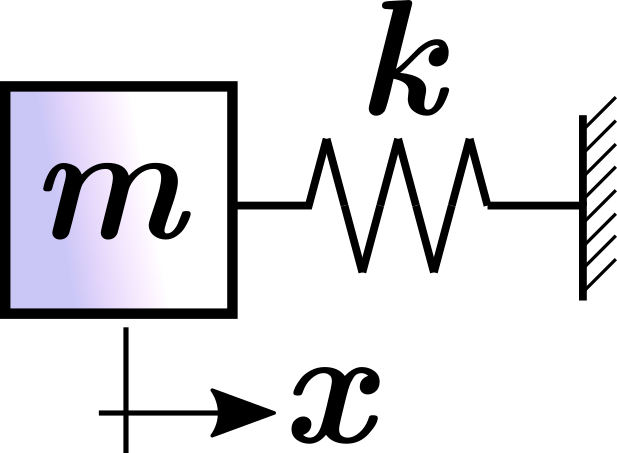

In [1]:
from IPython.display import Image
Image(filename='system-1DOF.png',width=400, height=200)

A ideia é simular um dano na estrutura através da perda de rigidez, isto é, progressivamente diminui-se o valor de **k**. Os dados em condição saudável (com **k** = 1000 N/m) e em situação com dano (com **k** menor do que 1000 N/m) são utilizados então em um processo de classificação, através do aprendizado com os dados em condição saudável e métricas de quantificação da qualidade da classificação utilizando dados de teste (tanto em condição saudável quanto em condição com dano). Esse processo tem por objetivo verificar quais *features* são melhores para se utilizar na detecção do dano para este caso e também a partir de qual porcentagem de perda de rigidez é possível detectar a presença do dano na dinâmica estrutural.

Os sinais que serão utilizados são obtidos via simulação numérica dada uma entrada do tipo sinal aleatório com 8192 amostras. Para cada condição, 100 testes foram feitos para garantir o elemento de aleatoriedade também no processo de aprendizado.

As *features* utilizadas neste estudo são:

1) Variance do sinal no domínio do tempo;

2) Kurtosis do sinal no domínio do tempo;

3) 2-Norm do sinal no domínio do tempo;

4) Índice $\gamma$, que é a razão da variância do sinal com dano/saudável(teste) e a variância do sinal de referência (saudável);

5) Natural frequency - via método de Welch;

6) RMSE do sinal no domínio do tempo;

7) Índice $\gamma_{AR}$, que, dado um modelo autoregressivo (AR) pré-determinado via sinal de referência, o índice $\gamma_{AR}$ é a razão entre a variância do erro de predição do sinal com dano/saudável(teste) e a variância do erro de predição do sinal de referência (saudável).

Para o processo de classificação, foi utilizada a Distância de Mahalanobis, com *features* diferentes em cada parte do estudo. Além disso, para a definição do threshold, são utilizados o máximo valor da referência (situação saudável) via `np.max()`, chi-square e IQR (Interquartile Range). Para o processo de aprendizado (treino) são utilizadas 50% das amostras em condição saudável enquanto os 50% restantes são usadas para validação.

Dividiremos o estudo em 3 partes:

**A)** Perda gradual de rigidez até 65% do valor total (original) com um incremento de -1%. São consideradas como *features* as de número 1) a 7) (todas) e as com melhores características para detecção são efetivamente utilizadas no processo. São levados em consideração na Distância de Mahalanobis a condição saudável e somente 5 condições com dano na construção da curva ROC e matrizes de confusão, sendo estas com as perdas de 1%, 10%, 20%, 30% e 34%.

**B)** Perda gradual de rigidez até 80% do valor total (original) com um incremento de -0.5%. São consideradas como *features* as de número 1) a 6) e as com melhores características para detecção são efetivamente utilizadas no processo. São levados em consideração na Distância de Mahalanobis a condição saudável e todas as condições com dano.

**C)** Perda gradual de rigidez até 80% do valor total (original) com um incremento de -0.5%. São consideradas como *features* as de número 1) a 7) (todas) e as com melhores características para detecção são efetivamente utilizadas no processo. São levados em consideração na Distância de Mahalanobis a condição saudável e todas as condições com dano.

Importando bibliotecas a serem utilizadas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, hanning
from scipy.spatial.distance import mahalanobis as mahal

# Caso A)

**Assume a single degree of freedom mechanical system with a linear spring of k = 1000 N/m and mass of m = 1 kg.**

In [3]:
# SDoF - mechanical system - Healthy
m = 1          # mass [kg]
k_0 = 1000     # stiffness [N/m]

In [4]:
Omega = np.sqrt(k_0/m)                           # natural frequency (rad/s)
Fn = Omega/(2*np.pi)                             # natural frequency (Hz)
H = signal.TransferFunction(1,[m, 0, k_0]);      # transfer function

**Numerical simulation**

In [5]:
Fs = 10*Fn                     # sampling frequency (Hz)
dt = 1/Fs                      # time period (s)
N = 8*1024;                    # number of samples
t = np.arange(0,N*dt,dt)       # time vector

u = np.random.randn(N, 1)      # random excitation (N)

**Healthy response**


In [6]:
y = signal.lsim(H,u,t);        # displacement (m)

**Plot of time response of healthy state**

In [7]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

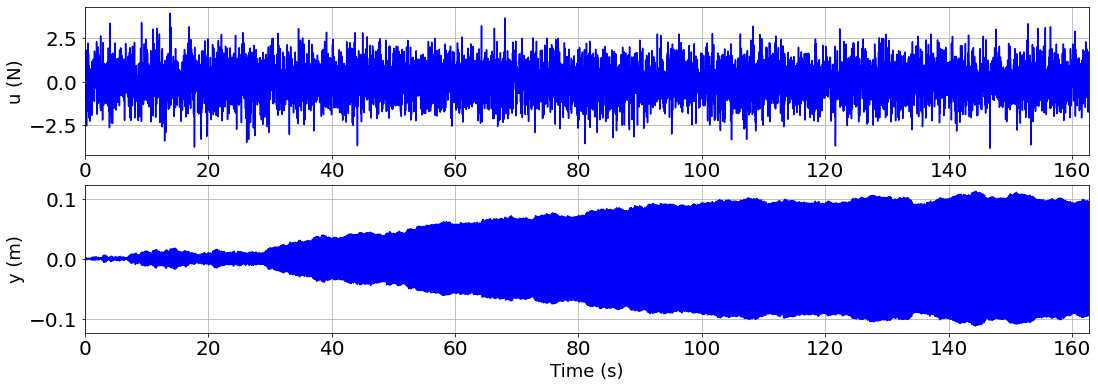

In [8]:
plt.figure(figsize=(18,6))

plt.subplot(2,1,1)
plt.plot(t,u,'blue')
#plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('u (N)',fontsize=18)
plt.xlim([0, t[N-1]])
plt.grid()

plt.subplot(2,1,2)
plt.plot(t,y[1],'blue')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.xlim([0, t[N-1]])
plt.grid()

plt.show()

**Power spectral density (PDF) of response using Welch method**



<ipython-input-9-e9dcdda9a1c5>:1: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  freq, Y = welch(y[1], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)


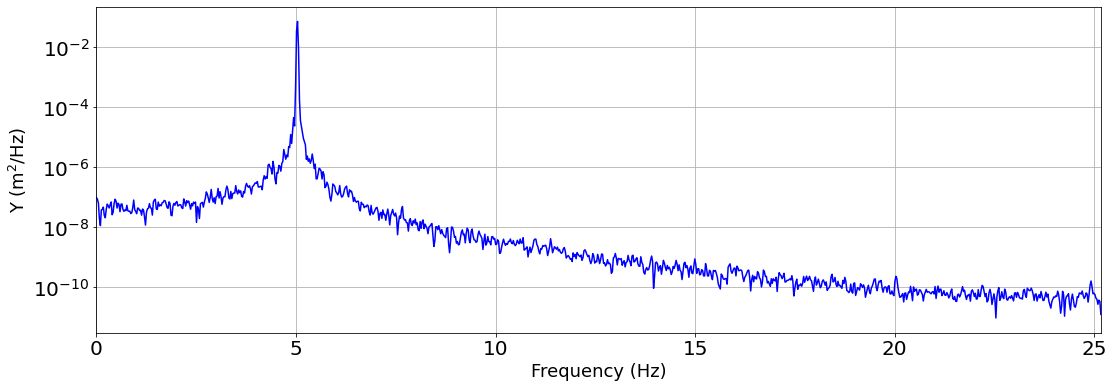

In [9]:
freq, Y = welch(y[1], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)

plt.figure(figsize=(18,6))
plt.plot(freq,Y,'blue')
plt.yscale('log')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Y (m$^2$/Hz)',fontsize=18)
plt.xlim([0, Fs/2])
plt.grid()
plt.show()

**Frequency Response Function (FRF)**

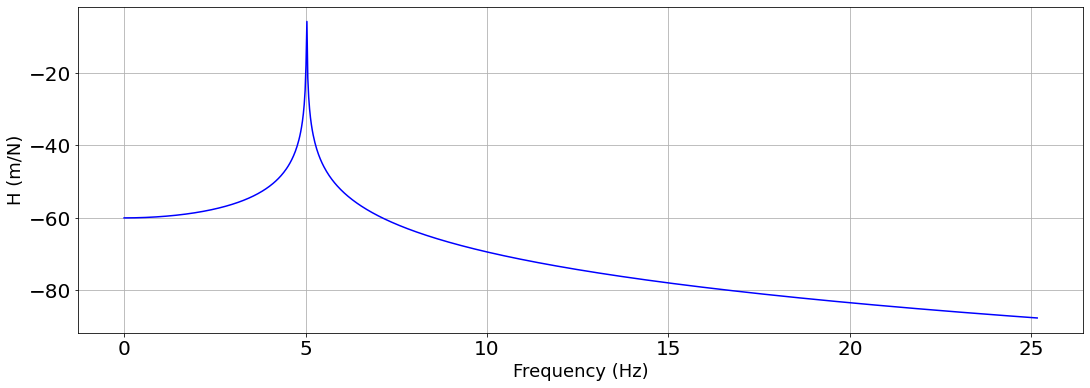

In [10]:
w, Mag, Phase = signal.bode(H,w=2*np.pi*freq)

plt.figure(figsize=(18,6))
plt.plot(w/(2*np.pi),Mag,'blue')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('H (m/N)',fontsize=18)
plt.grid()
plt.show()
#plt.xlim([0, Fs/2])

 **Compute:**

# 1. Generate many output vibration data for the healthy condition and assume reduced stiffness spaced equality of 1%. Use random excitation force to simulate variabilities.

Aqui vamos adotar uma redução de até 65% na rigidez (`k_0`) com passos de 1% na redução e 100 amostras de sinal para cada condição, sendo cada amostra composta por 8192 pontos.

In [11]:
import sys

kd = np.arange(99,64,-1)*0.01*k_0     # reduction
Rep = 100
yh = np.zeros((Rep,N))
yd = np.zeros((Rep,N,len(kd)))
Yd = np.zeros((Rep,np.int(N/8)+1,len(kd)))

for k in range(0,Rep):
    
    u = np.random.randn(N,1)
    yh[k,:] = signal.lsim(H,u,t)[1];       # health state
 
    for i in range(0, len(kd)):
      
        Hd = signal.TransferFunction(1,[m, 0, kd[i]]);                         # damage model
        u = np.random.randn(N,1);                                              # random excitation (N)
        yd[k,:,i] = signal.lsim(Hd,u,t)[1]
        
        freq, aux = welch(yd[k,:,i], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)

        #[aux,freq] = pwelch(squeeze(yd(k,:,i)),hanning(N/4),N/8,N/4,Fs);       # healthy state
        Yd[k,:,i] = aux
        sys.stdout.flush()
        sys.stdout.write("\rProgress: {} %".format((k/(Rep-1)*100)))

Progress: 0.0 %

<ipython-input-11-33592204be3e>:20: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  freq, aux = welch(yd[k,:,i], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)


Progress: 100.0 %9898989899 %%

Em toda a análise do Caso **A)**, as legendas D1, D2, D3, D4 e D5 correspondem, respectivamente, às porcentagens de perda de rigidez de 1%, 10%, 20%, 30% e 34%.

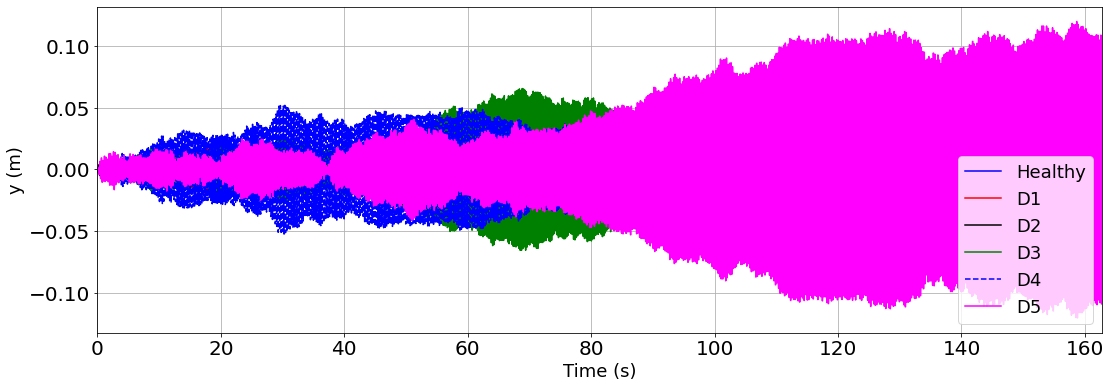

In [12]:
plt.figure(figsize=(18,6))
plt.plot(t,yh[20,:],'blue',label='Healthy')
plt.plot(t,yd[20,:,0],'red',label='D1')
plt.plot(t,yd[20,:,9],'black',label='D2')
plt.plot(t,yd[20,:,19],'green',label='D3')
plt.plot(t,yd[20,:,29],color='blue',linestyle='--',label='D4')
plt.plot(t,yd[20,:,33],'magenta',label='D5')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()
plt.xlim([0, t[N-1]])
plt.show()

**Variação da frequência natural com a diminuição do valor da rigidez.**
Observa-se que conforme ocorre a perda de rigidez, uma vez que a frequência natural é calculada por $\omega_n=\sqrt{k/m}$, tem-se o deslocamento para a esquerda, conforme mostra o gráfico. Este comportamento pode indicar um bom candidato para o processo de classificação que é feito posteriormente.

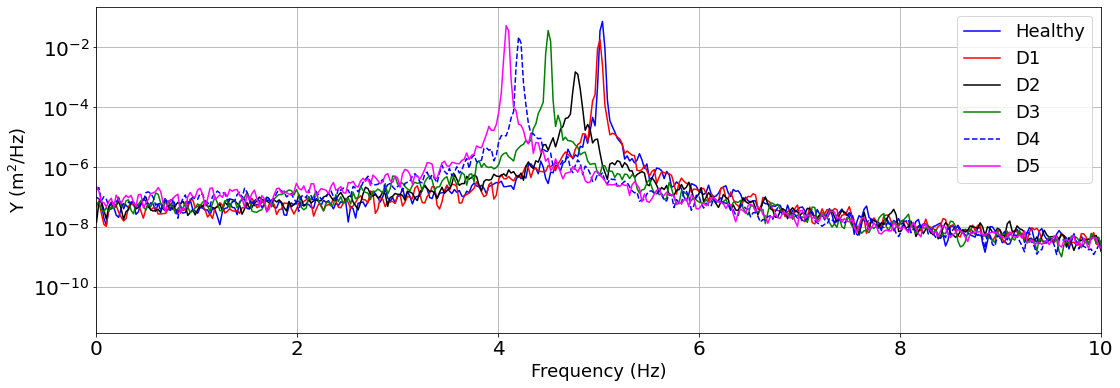

In [13]:
plt.figure(figsize=(18,6))
plt.plot(freq,Y,'blue',label='Healthy')
plt.plot(freq,Yd[20,:,0],'red',label='D1')
plt.plot(freq,Yd[20,:,9],'black',label='D2')
plt.plot(freq,Yd[20,:,19],'green',label='D3')
plt.plot(freq,Yd[20,:,29],color='blue',linestyle='--',label='D4')
plt.plot(freq,Yd[20,:,33],'magenta',label='D5')
plt.yscale('log')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Y (m$^2$/Hz)',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()
plt.xlim([0,10])
plt.show()

# 2. Proposed and extract a list of possible features from these vibration signals to label the structural state. Compare the performance of both to decide what is the best combination to compute a damage index.

Como dito anteriormente, aqui iremos analisar as *features* e selecionar para aplicação na Distância de Mahalanobis aquelas que possuem tendência a serem bons indicadores de dano.

**Compute a feature - variance of displacement**

In [14]:
from scipy.stats import norm, kurtosis

In [15]:
reference = np.var(y[1]) 

Ih = np.zeros((Rep,1))
I1h = np.zeros((Rep,1))
I2h = np.zeros((Rep,1))
Gammah = np.zeros((Rep,1))

Id = np.zeros((len(kd),Rep))
I1d = np.zeros((len(kd),Rep))
I2d = np.zeros((len(kd),Rep))
Gammad = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    
    Ih[k] = np.var(yh[k,:])
    I1h[k] = kurtosis(yh[k,:])
    I2h[k] = np.linalg.norm(yh[k,:])
    Gammah[k] = Ih[k]/reference
    
    for i in range(0,len(kd)):
        
      Id[i,k] = np.var(yd[k,:,i])
      I1d[i,k] = kurtosis(yd[k,:,i])
      I2d[i,k] = np.linalg.norm(yd[k,:,i])
      Gammad[i,k] = Id[i,k]/reference

**Box features**

Nos gráficos a seguir, **H** representa a situação saudável e **D1** a **D5** as situações com dano, sendo **D1** o dano menos severo e **D5** o dano mais severo.

**Variance** - Variância do sinal no domínio do tempo.

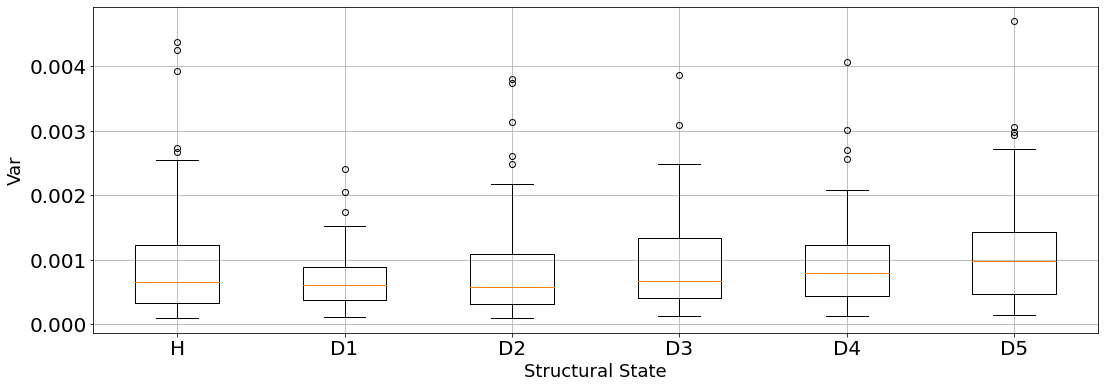

In [16]:
# Variance
plt.figure(figsize=(18,6))
plt.boxplot([Ih[:,0].T, Id[1-1,:], Id[10-1,:], Id[20-1,:], Id[30-1,:], Id[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('Var',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Kurtosis** - Kurtosis do sinal no domínio do tempo.

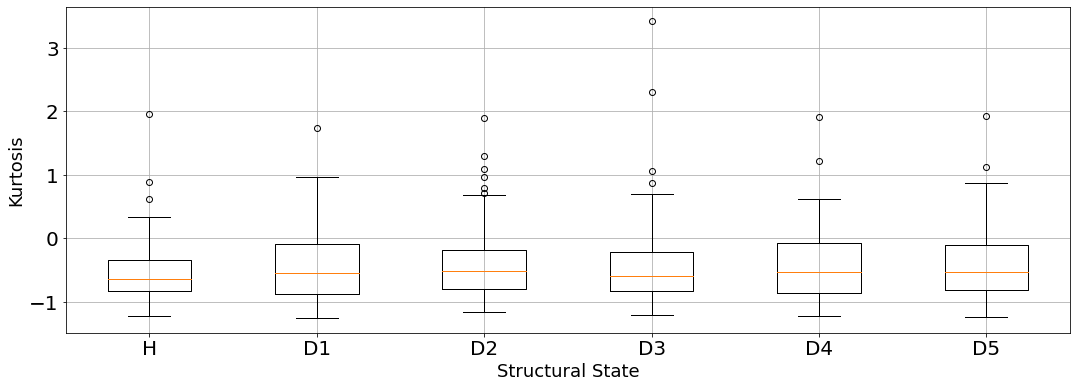

In [17]:
# Kurtosis
plt.figure(figsize=(18,6))
plt.boxplot([I1h[:,0].T, I1d[1-1,:], I1d[10-1,:], I1d[20-1,:], I1d[30-1,:], I1d[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('Kurtosis',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**2-Norm** - 2-Norm do sinal no domínio do tempo.

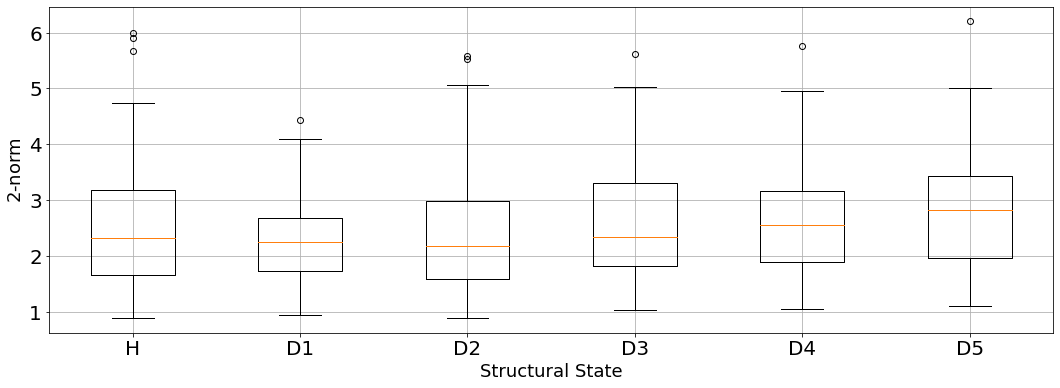

In [18]:
# 2-Norm
plt.figure(figsize=(18,6))
plt.boxplot([I2h[:,0].T, I2d[1-1,:], I2d[10-1,:], I2d[20-1,:], I2d[30-1,:], I2d[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$2$-norm',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Space of features**

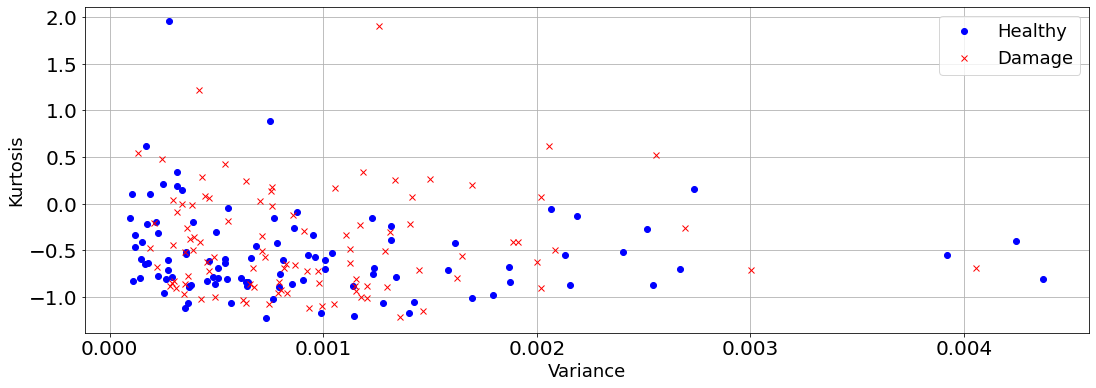

In [19]:
plt.figure(figsize=(18,6))
plt.plot(Ih,I1h,'ob',label='Healthy')
plt.plot(Id[30-1,:],I1d[30-1,:],'xr',label='Damage')
plt.legend(loc='best',fontsize=18)
plt.grid()
plt.xlabel('Variance',fontsize=18)
plt.ylabel('Kurtosis',fontsize=18)
plt.show()

**Gamma** - índice $\gamma$ do sinal no domínio do tempo, calculado por **Variance(sinal com dano/saudável) / Variance(sinal de referência)**

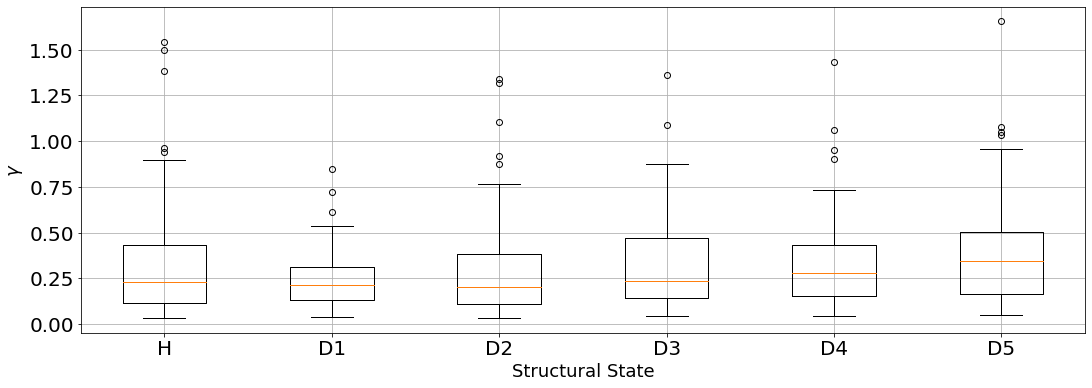

In [20]:
# Gamma
plt.figure(figsize=(18,6))
plt.boxplot([Gammah[:,0].T, Gammad[1-1,:], Gammad[10-1,:], Gammad[20-1,:], Gammad[30-1,:], Gammad[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$\gamma$',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Extracting Natural Frequency**

Aqui são tomados os valores de frequência natural, isto é, o valor da frequência no pico da resposta no domínio da frequência, para todas as condições (saudável e com dano). Verificaremos se este é, de fato, um possível candidato para atuar como *feature* na classificação.



In [21]:
# Healthy state

FeatWh = np.zeros((Rep,1))
FeatW = np.zeros((Rep,len(kd)))

for k in range(0,Rep):
  FeatWh[k] = Fn + 0.01*np.random.randn(1)*Fn

# Damage
for k in range(0,Rep):   
    for i in range(0,len(kd)):
        for j in range(0,len(freq)):
            if Yd[k,j,i]==np.max(Yd[k,:,i]):
              FeatW[k,i]= freq[j]+0.01*np.random.randn(1)*freq[j]

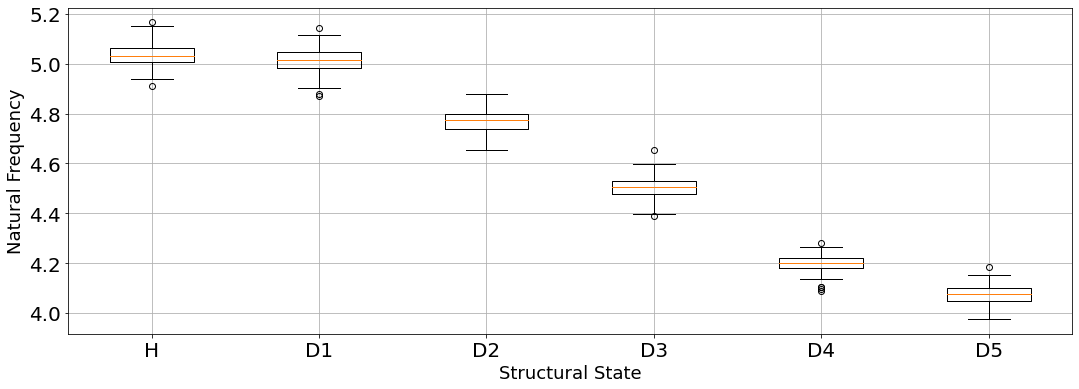

In [22]:
# Natural Frequency

plt.figure(figsize=(18,6))
plt.boxplot([np.transpose(FeatWh[:,0]), np.transpose(FeatW[:,1-1]), np.transpose(FeatW[:,10-1]),
             np.transpose(FeatW[:,20-1]), np.transpose(FeatW[:,30-1]), np.transpose(FeatW[:,34-1])],labels=['H','D1','D2','D3','D4','D5'])
plt.grid()
plt.xlabel('Structural State',fontsize=18)
plt.ylabel('Natural Frequency',fontsize=18)
plt.show()

Observa-se que existem diferenças consideráveis (medianas são diferentes e não há sobreposição dos boxplots) entre a condição saudável e com dano, de modo que a frequência natural, assim, será usada como *feature*.

**RMSE from signals in time domain**

In [23]:
rmseh = np.zeros((Rep,1))
rmsed = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    rmseh[k] = np.linalg.norm(yh[k,:] - y[1]) / np.sqrt(len(y[1]))

    for i in range(0,len(kd)):
      rmsed[i,k] = np.linalg.norm(yd[k,:,i] - y[1]) / np.sqrt(len(y[1]))

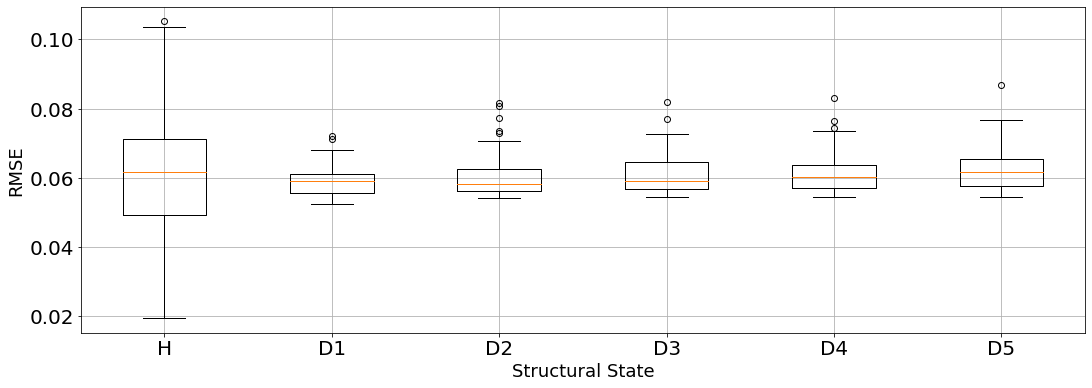

In [24]:
# RMSE
plt.figure(figsize=(18,6))
plt.boxplot([rmseh[:,0].T, rmsed[1-1,:], rmsed[10-1,:], rmsed[20-1,:], rmsed[30-1,:], rmsed[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('RMSE',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**AR Model**

Vamos agora, a partir de uma amostra de dados em situação saudável, estimar a ordem de um modelo autoregressivo (AR) pelo critério de Akaike e, com isso, de fato extrair os coeficientes e com o modelo calculado, estimar os erros de predição para todas as condições (as demais em condição saudável e todas com dano). Com os erros calculados, será computado o índice $\gamma_{AR}$, que é dado pela razão entre a variância do erro da situação com dano/saudável e a variância do erro na situação de referência (amostra saudável usada na obtenção do modelo). O índice $\gamma_{AR}$ será, assim, o candidato a *feature* em nosso estudo.

In [25]:
from statsmodels.tsa.ar_model import AutoReg

In [26]:
import warnings
warnings.filterwarnings('ignore')

order = 20                                             # Order model
akaike = np.zeros((order,1))
nt = np.random.randint(0, Rep-1)                       # Random sample

for i in range(1,order):
    model = AutoReg(yh[nt,:], lags=i).fit()            # AR model
    akaike[i] = model.aic                              # Akaike's Information Criterion 

**Estimativa da ordem do modelo segundo o critério de Akaike (AIC)**

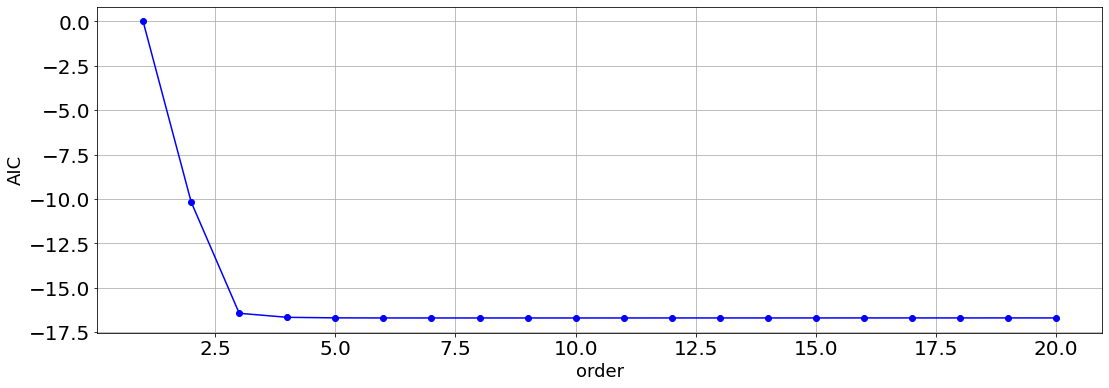

In [27]:
plt.figure(figsize=(18,6))
plt.plot(np.arange(1,order+1,1),akaike,'ob-')
plt.xlabel('order',fontsize=18)
plt.ylabel('AIC',fontsize=18)
plt.grid()
plt.show()

**Escolha da ordem igual a 4 segundo o critério de Akaike**

In [28]:
na = 4                                      # order
nt = np.random.randint(0, Rep-1)
model_h = AutoReg(yh[nt,:],lags=na).fit();  # reference model
print(model_h.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 8192
Model:                     AutoReg(4)   Log Likelihood               56821.417
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sat, 08 May 2021   AIC                            -16.716
Time:                        14:58:23   BIC                            -16.710
Sample:                             4   HQIC                           -16.714
                                 8192                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.094e-06   2.59e-06      0.422      0.673   -3.98e-06    6.17e-06
y.L1           2.1484      0.011    197.531      0.000       2.127       2.170
y.L2          -2.0358      0.025    -83.085      0.0

**Extraindo coeficientes do modelo**

In [29]:
a_0 = model_h.params[0]
a_1 = model_h.params[1]
a_2 = model_h.params[2]
a_3 = model_h.params[3]
a_4 = model_h.params[4]

**Predição do modelo - saudável e com dano**

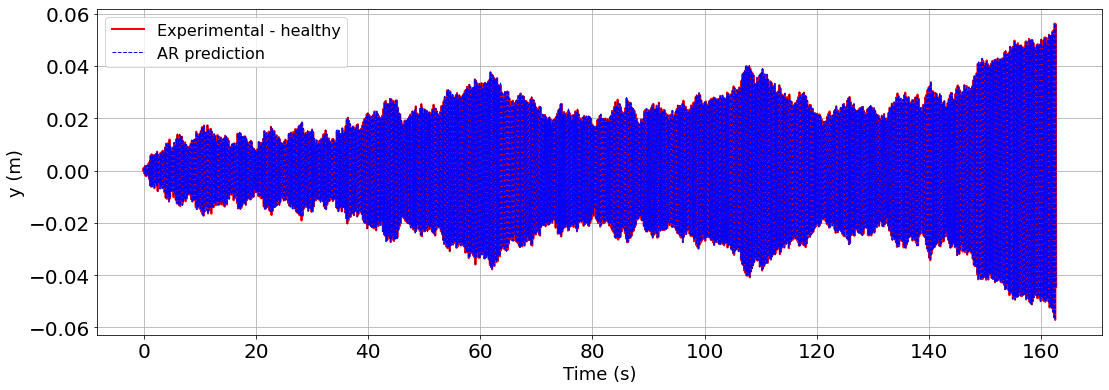

In [30]:
yp = np.zeros((len(t)-na,1))
e_ref = np.zeros((len(t)-na,1))
cont_ = na

for cont in range(0,len(t)-na):
    yp[cont] = a_0 + a_1*yh[nt,cont_-1] + a_2*yh[nt,cont_-2] + a_3*yh[nt,cont_-3] + a_4*yh[nt,cont_-4]
    e_ref[cont] = (yp[cont] - yh[nt,cont+na])**2
    cont_ += 1

Ref = np.var(e_ref)  
    
plt.figure(figsize=(18,6))
plt.plot(t-t[na],yh[nt,:],'r',linewidth=2,label='Experimental - healthy')
plt.plot(t[0:-na],yp,'b--',linewidth=1,label='AR prediction')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.grid()
#plt.xlim([0,5])
plt.legend(loc='best',fontsize=16)
plt.show()

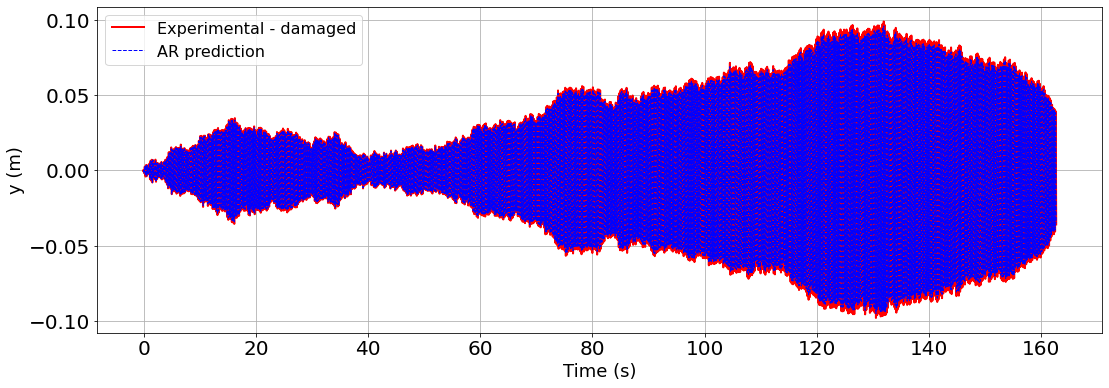

In [31]:
yp = np.zeros((len(t)-na,1))
nt = np.random.randint(0, Rep-1)
nt_ = np.random.randint(0, len(kd)-1)
e_dam = np.zeros((len(t)-na,1))
cont_ = na

for cont in range(0,len(t)-na):
    yp[cont] = a_0 + a_1*yd[nt,cont_-1,nt_] + a_2*yd[nt,cont_-2,nt_] + a_3*yd[nt,cont_-3,nt_] + a_4*yd[nt,cont_-4,nt_]
    e_dam[cont] = (yp[cont] - yd[nt,cont+na,nt_])**2
    cont_ += 1

plt.figure(figsize=(18,6))
plt.plot(t-t[na],yd[nt,:,nt_],'r',linewidth=2,label='Experimental - damaged')
plt.plot(t[0:-na],yp,'b--',linewidth=1,label='AR prediction')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.grid()
#plt.xlim([50,55])
plt.legend(loc='best',fontsize=16)
plt.show()

**Distribuição do erro (histograma)**

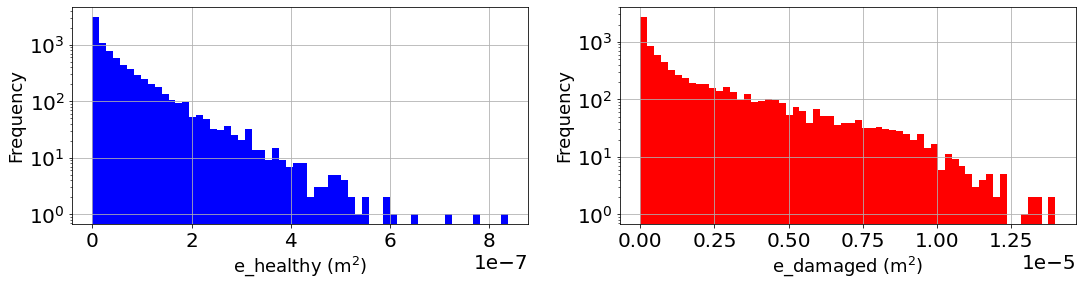

In [32]:
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
plt.hist(e_ref,bins=60,color='blue')
plt.xlabel('e_healthy (m$^2$)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.yscale('log')
plt.grid()

plt.subplot(1,2,2)
plt.hist(e_dam,bins=60,color='red')
plt.xlabel('e_damaged (m$^2$)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.yscale('log')
plt.grid()

plt.show()

**Cálculo do índice $\gamma_{AR}$**

In [33]:
erro_h = np.zeros((Rep,1))
Gammah_AR = np.zeros((Rep,1))

erro_d = np.zeros((len(kd),Rep))
Gammad_AR = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    cont_ = na
    e_h = np.zeros((len(t)-na,1))
    yp = np.zeros((len(t)-na,1))
    
    for cont in range(0,len(t)-na):
        yp[cont] = a_0 + a_1*yh[k,cont_-1] + a_2*yh[k,cont_-2] + a_3*yh[k,cont_-3] + a_4*yh[k,cont_-4]
        e_h[cont] = (yp[cont] - yh[k,cont+na])**2
        cont_ += 1
    
    erro_h[k] = np.var(e_h)
    Gammah_AR[k] = erro_h[k] / Ref
        
    for i in range(0,len(kd)):
        
            cont_ = na
            e_d = np.zeros((len(t)-na,1))
            yp_ = np.zeros((len(t)-na,1))
            
            for cont in range(0,len(t)-na):
                yp_[cont] = a_0 + a_1*yd[k,cont_-1,i] + a_2*yd[k,cont_-2,i] + a_3*yd[k,cont_-3,i] + a_4*yd[k,cont_-4,i]
                e_d[cont] = (yp_[cont] - yd[k,cont+na,i])**2
                cont_ += 1
        
            erro_d[i,k] = np.var(e_d)
            Gammad_AR[i,k] = erro_d[i,k] / Ref
            
    sys.stdout.flush()
    sys.stdout.write("\rProgress: {} %".format((k/(Rep-1)*100)))

Progress: 100.0 %9898989899 %%

**Comportamento do índice $\gamma_{AR}$ nas situações saudável e com dano**

Pode-se notar que conforme a severidade do dano aumenta, o valor do índice cresce consideravelmente. Portanto, este também é um bom candidato a *feature*.

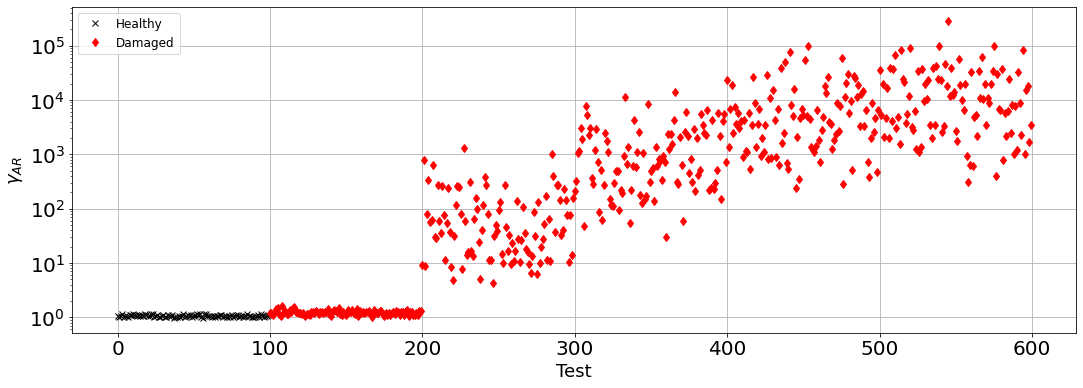

In [34]:
plt.figure(figsize=(18,6))
plt.plot(np.arange(0,100,1),Gammah_AR, 'xk',label='Healthy')
plt.plot(np.arange(100,200,1),Gammad_AR[1-1,:],'dr',label='Damaged')
plt.plot(np.arange(200,300,1),Gammad_AR[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Gammad_AR[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Gammad_AR[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Gammad_AR[34-1,:],'dr')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$\gamma_{AR}$',fontsize=18)
plt.grid()
plt.show()

**Boxplots** - $\gamma_{AR}$

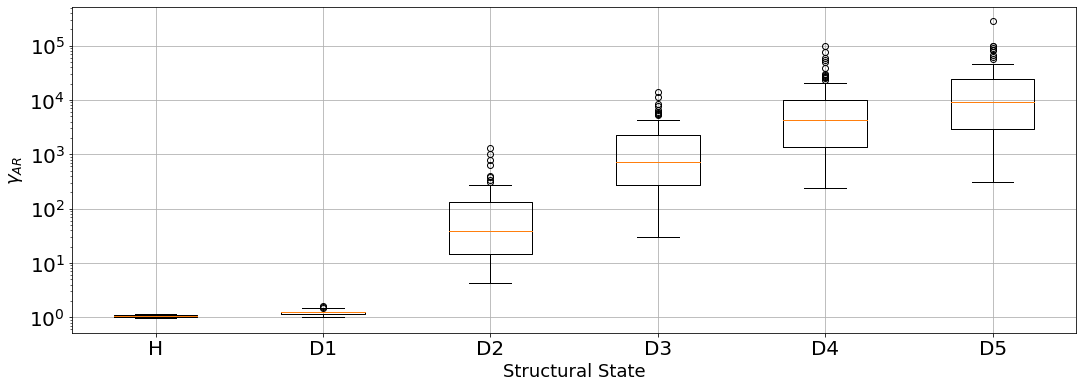

In [35]:
# Gamma_AR
plt.figure(figsize=(18,6))
plt.boxplot([Gammah_AR[:,0].T, Gammad_AR[1-1,:], Gammad_AR[10-1,:], Gammad_AR[20-1,:], Gammad_AR[30-1,:], Gammad_AR[34-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$\gamma_{AR}$',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.yscale('log')
plt.show()

**Space of features**

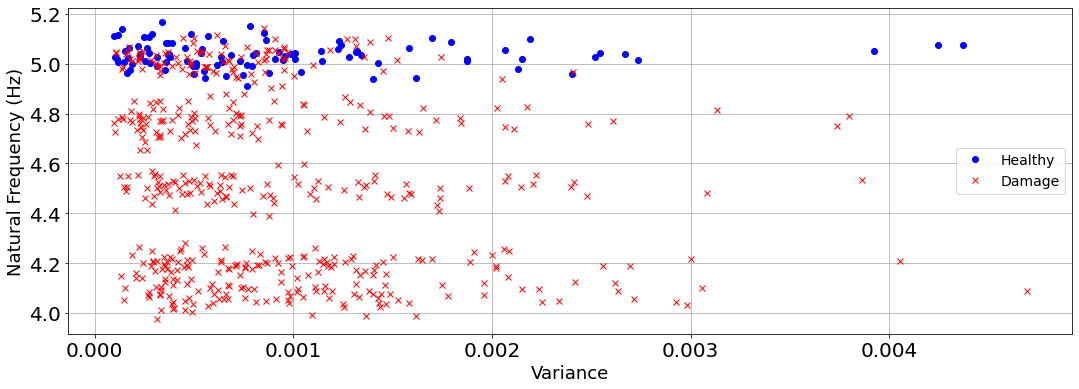

In [36]:
plt.figure(figsize=(18,6))
plt.plot(Ih,FeatWh,'ob',label='Healthy')
plt.plot(Id[1-1,:], FeatW[:,1-1],'xr',label='Damage')
plt.plot(Id[10-1,:], FeatW[:,10-1],'xr')
plt.plot(Id[20-1,:], FeatW[:,20-1],'xr')
plt.plot(Id[30-1,:], FeatW[:,30-1],'xr')
plt.plot(Id[34-1,:], FeatW[:,34-1],'xr')
plt.legend(loc='best',fontsize=14)
plt.xlabel('Variance',fontsize=18)
plt.ylabel('Natural Frequency (Hz)',fontsize=18)
plt.grid()
plt.show()

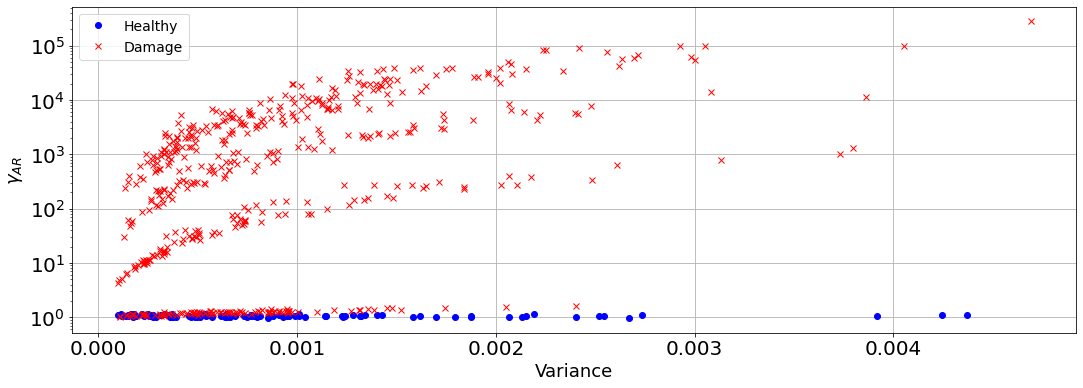

In [37]:
plt.figure(figsize=(18,6))
plt.plot(Ih,Gammah_AR[:,0].T,'ob',label='Healthy')
plt.plot(Id[1-1,:], Gammad_AR[1-1,:],'xr',label='Damage')
plt.plot(Id[10-1,:], Gammad_AR[10-1,:],'xr')
plt.plot(Id[20-1,:], Gammad_AR[20-1,:],'xr')
plt.plot(Id[30-1,:], Gammad_AR[30-1,:],'xr')
plt.plot(Id[34-1,:], Gammad_AR[34-1,:],'xr')
plt.legend(loc='best',fontsize=14)
plt.xlabel('Variance',fontsize=18)
plt.ylabel('$\gamma_{AR}$',fontsize=18)
plt.yscale('log')
plt.grid()
plt.show()

Observamos pelos gráficos da seção 2. que as melhores *features* para a classificação são a frequência natural e o índice $\gamma_{AR}$. Iremos utilizar, além destes, o índice $\gamma$ e, assim, estas três *features* irão compor os elementos a serem utilizados na Distância de Mahalanobis.

# 3. Determine the Mahalanobis square distance using half sample of the healthy data as learning data and healthy data and all damaged data to validate. Perform it randomly, assuming a variable number of samples for learning (training) and validate (testing). Discuss the use of other possible damage index.

No presente estudo, foi utilizada a distância de Mahalanobis, indicada com $D^2$. Outro índice de dano como a distância Euclidiana poderia ser utilizado neste trabalho, com as devidas transformações e poderia ser feita, por exemplo, uma comparação entre índices (Mahalanobis e Euclidiana). Poderia ser feito também um estudo acerca da aplicação de Análise de Componente Principal (PCA) junto a algum método supervisionado como classificação por K-Nearest Neighbor (KNN) ou algum outro. Além disso, dada a progressiva perda de rigidez, poderia-se estudar uma possível separação em clusters (saudável, dano pequeno, dano médio e dano grave), atribuindo a cada tipo um limite específico.

**Learning features**

In [38]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]

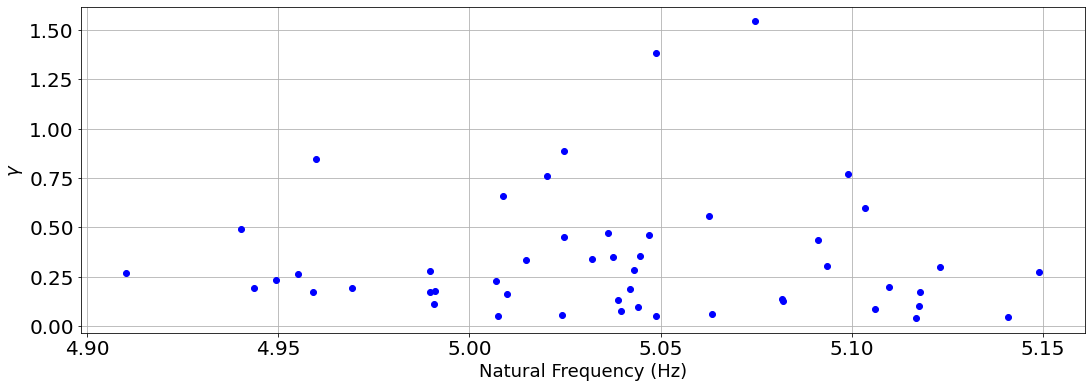

In [39]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]
valida = observation[np.int(np.round(0.5*Rep)):Rep]

# Learning data
Xh = np.transpose(FeatWh[learn])
Yh = np.transpose(Gammah[learn])
Zh = np.transpose(Gammah_AR[learn])

plt.figure(figsize=(18,6))
plt.plot(Xh,Yh,'bo')
plt.xlabel('Natural Frequency (Hz)',fontsize=18)
plt.ylabel('$\gamma$',fontsize=18)
plt.grid()
plt.show()

**Validation data - healthy state**

No gráfico abaixo encontram-se os dados de validação para estrutura saudável e com dano considerando índice $\gamma$ e a frequência natural.

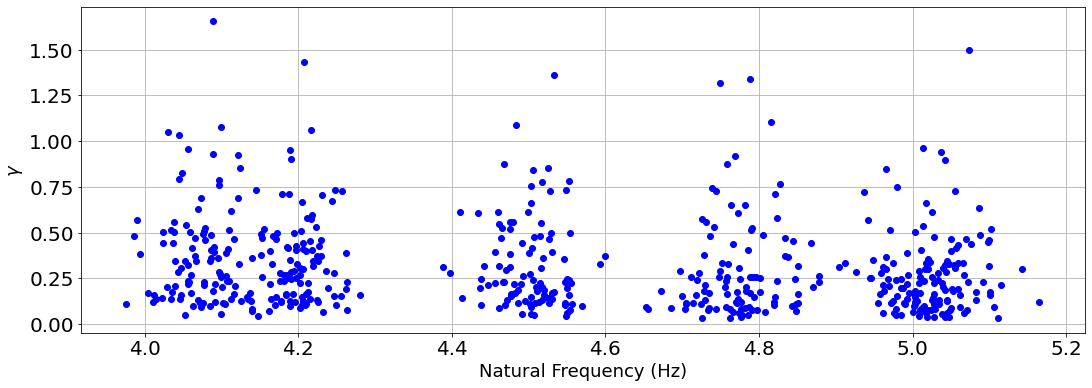

In [40]:
Xhv = np.transpose(FeatWh[valida])
Yhv = np.transpose(Gammah[valida])
Zhv = np.transpose(Gammah_AR[valida])

# Validation data - damaged state
G = np.array([Gammad[0,:], Gammad[10-1,:], Gammad[20-1,:], Gammad[30-1,:], Gammad[34-1,:]])
F = np.array([FeatW[:,0], FeatW[:,10-1], FeatW[:,20-1], FeatW[:,30-1], FeatW[:,34-1]])
E = np.array([Gammad_AR[0,:], Gammad_AR[10-1,:], Gammad_AR[20-1,:], Gammad_AR[30-1,:], Gammad_AR[34-1,:]])

plt.figure(figsize=(18,6))
plt.plot(Xhv, Yhv, 'bo')
plt.plot(F,G,'bo')
plt.ylabel('$\gamma$',fontsize=18); 
plt.xlabel('Natural Frequency (Hz)',fontsize=18); 
plt.grid()
plt.show()

**Learning a statistical model**

Instalando a biblioteca para cálculo da distância de Mahalanobis.

In [41]:
!pip install mahalanobis

In [42]:
from mahalanobis import Mahalanobis

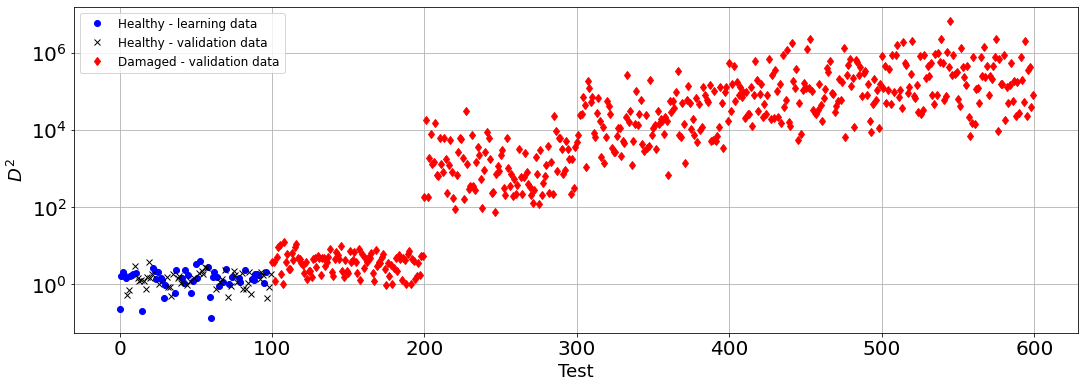

In [43]:
Disth = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))
Disth_dist = Disth.calc_distances(np.concatenate([Xh,Yh,Zh],axis=0).T)                 # learning

Disthv = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))
Disthv_dist = Disthv.calc_distances(np.concatenate([Xhv,Yhv,Zhv],axis=0).T)            # healthy validation

Distd = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))

Distd_dist_D1 = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[0,5,10],:].T)     # damaged validation
Distd_dist_D2 = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[1,6,11],:].T)     # damaged validation
Distd_dist_D3 = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[2,7,12],:].T)     # damaged validation
Distd_dist_D4 = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[3,8,13],:].T)     # damaged validation
Distd_dist_D5 = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[4,9,14],:].T)     # damaged validation

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_D1,'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_D2,'dr')
plt.plot(np.arange(300,400,1),Distd_dist_D3,'dr')
plt.plot(np.arange(400,500,1),Distd_dist_D4,'dr')
plt.plot(np.arange(500,600,1),Distd_dist_D5,'dr')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 4. Compute the threshold value to a binary classification (healthy or damaged state) using at least two approaches.

Aqui usaremos o valor máximo dos dados de aprendizado via `np.max()`, chi-square (o número de graus de liberdade será a dimensão do índice de dano $D^2$, nesse caso 3) e intervalo interquartílico (IQR - InterQuartile Range).

**Threshold**

**Using np.max()**

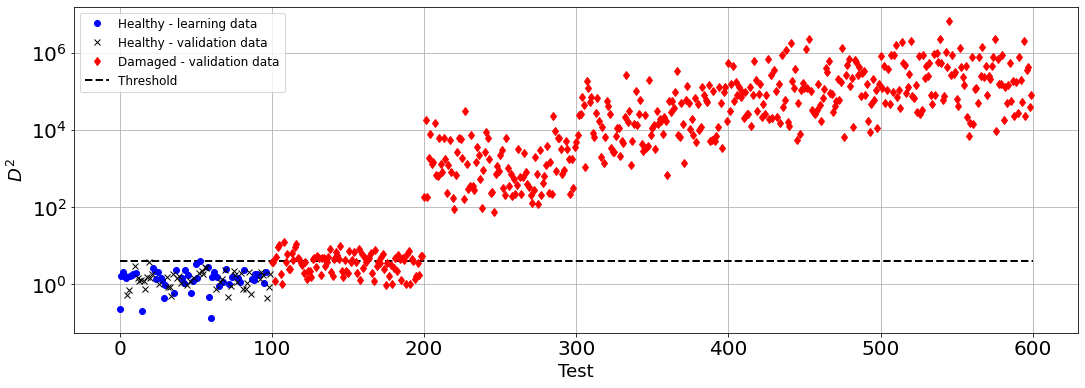

In [44]:
plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_D1,'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_D2,'dr')
plt.plot(np.arange(300,400,1),Distd_dist_D3,'dr')
plt.plot(np.arange(400,500,1),Distd_dist_D4,'dr')
plt.plot(np.arange(500,600,1),Distd_dist_D5,'dr')
plt.hlines(np.max(Disth_dist),0,600,color='black',linestyle='--',linewidth=2,label='Threshold')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

**Chi-Square**

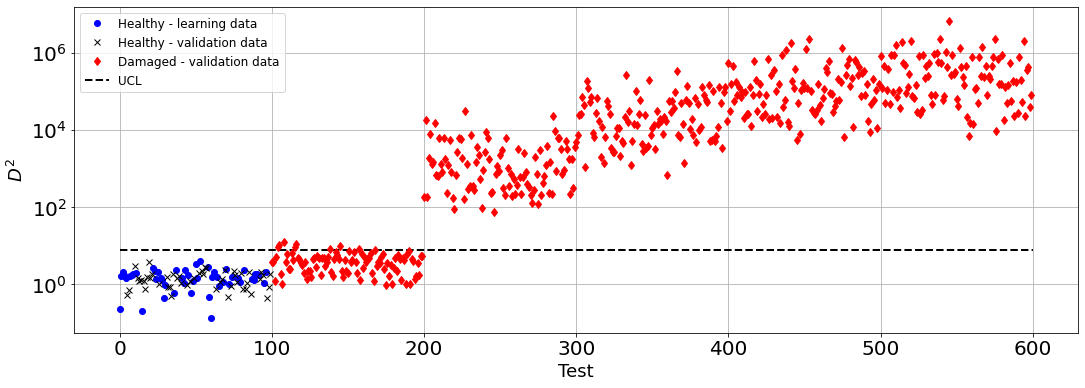

In [45]:
from scipy.stats.distributions import chi2

PFA = 0.05
m = len(Disth_dist)                     # same the number of observation in the learning data
degFreedom = 3
UCL_chi2 = chi2.ppf(1-PFA, df=degFreedom)

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_D1,'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_D2,'dr')
plt.plot(np.arange(300,400,1),Distd_dist_D3,'dr')
plt.plot(np.arange(400,500,1),Distd_dist_D4,'dr')
plt.plot(np.arange(500,600,1),Distd_dist_D5,'dr')
plt.hlines(UCL_chi2,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

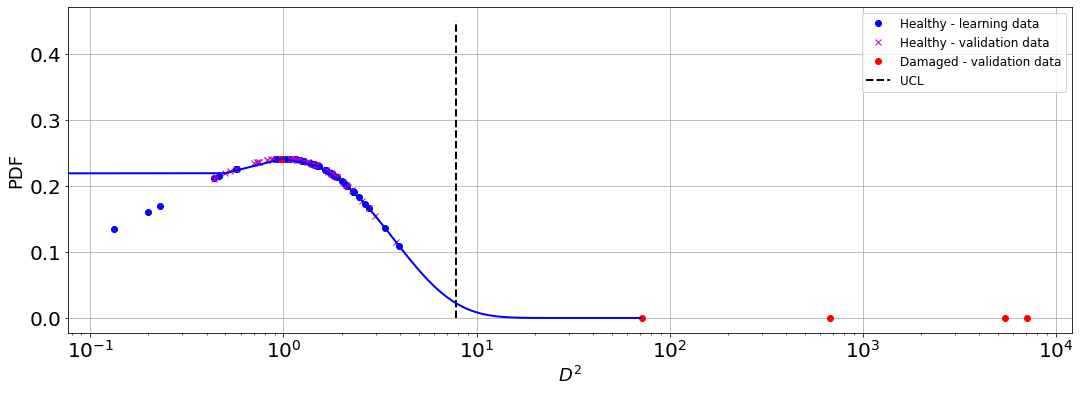

In [46]:
degf = 3

pdf = chi2.pdf(Disth_dist,degf)
pdfv = chi2.pdf(Disthv_dist,degf)
pdfd1 = chi2.pdf(np.min(Distd_dist_D1),degf)
pdfd2 = chi2.pdf(np.min(Distd_dist_D2),degf)
pdfd3 = chi2.pdf(np.min(Distd_dist_D3),degf)
pdfd4 = chi2.pdf(np.min(Distd_dist_D4),degf)
pdfd5 = chi2.pdf(np.min(Distd_dist_D5),degf)

x = np.arange(0,71,0.5)
y4 = np.zeros(len(x))
for i in range(0,len(x)):
  y4[i] = chi2.pdf(x[i],degf)

plt.figure(figsize=(18,6))
plt.plot(Disth_dist, pdf, 'bo',label='Healthy - learning data')
plt.plot(Disthv_dist, pdfv, 'xm',label='Healthy - validation data')
plt.plot(np.min(Distd_dist_D1),pdfd1,'or',label='Damaged - validation data')
plt.plot(np.min(Distd_dist_D2),pdfd2,'or')
plt.plot(np.min(Distd_dist_D3),pdfd3,'or')
plt.plot(np.min(Distd_dist_D4),pdfd4,'or')
plt.plot(np.min(Distd_dist_D5),pdfd5,'or')
plt.vlines(UCL_chi2,0,0.45,color='black',linestyle='--',linewidth=2,label='UCL')
plt.plot(x,y4,'b',linewidth=2)
plt.legend(loc='best',fontsize=12)
plt.xlabel('$D^2$',fontsize=18)
plt.ylabel('PDF',fontsize=18)
plt.xscale('log')
plt.grid()
plt.show()

**Using IQR Rule**

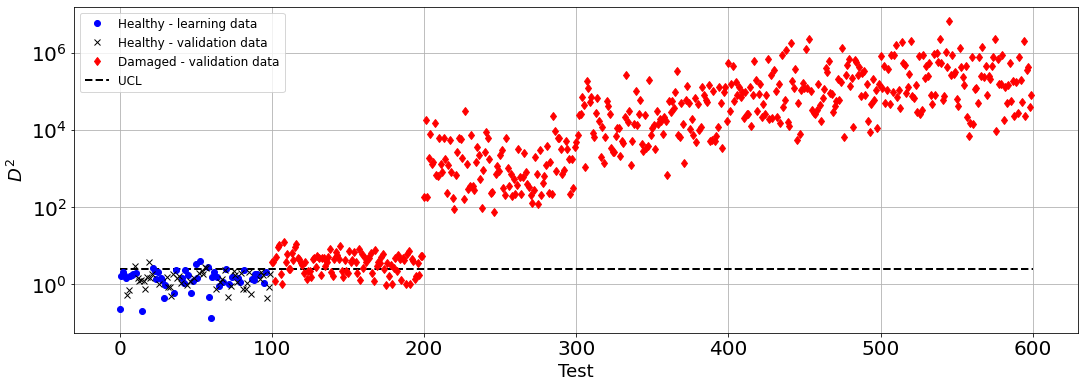

In [47]:
X = np.sort(Disth_dist)
M = np.median(Disth_dist)
X = np.sort(Disth_dist)

aux1 = []
aux2 = []

for i in range(1,len(Disth_dist)):
    if X[i]<M:
      aux1.append(X[i])    
    
    if X[i]>M:
      aux2.append(X[i])
    
Q1 = np.median(aux1) 
Q3 = np.median(aux2)
IQR = Q3-Q1
UCL_IRQ = Q1+1.5*IQR

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_D1,'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_D2,'dr')
plt.plot(np.arange(300,400,1),Distd_dist_D3,'dr')
plt.plot(np.arange(400,500,1),Distd_dist_D4,'dr')
plt.plot(np.arange(500,600,1),Distd_dist_D5,'dr')
plt.hlines(UCL_IRQ,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 5. Compute the confusing matrix with the probability of detection and probability of false alarm. Show the ROC curve.

Confusion matrix model used: [link](https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png)

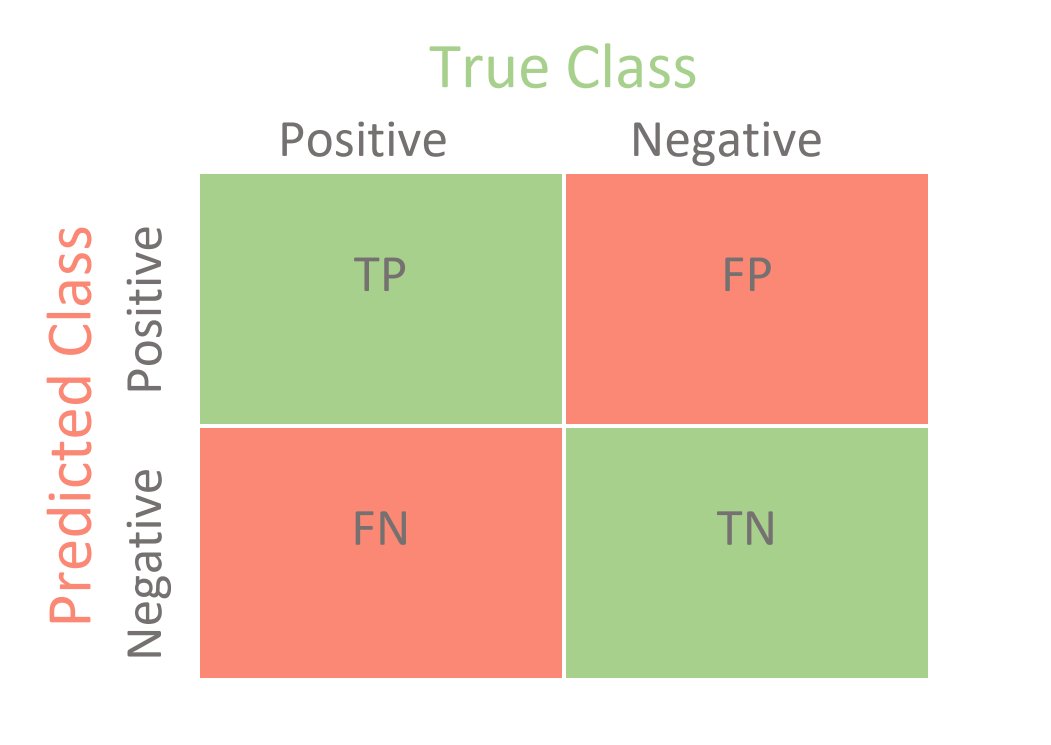

**Using np.max() as threshold**

In [48]:
import pandas as pd

FP, TP, FN, TN = 0, 0, 0, 0

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>np.max(Disth_dist):
    FP += 1

for i in range(0,len(Distd_dist_D1)):
  if Distd_dist_D1[i]<np.max(Disth_dist):
    FN += 1
  if Distd_dist_D2[i]<np.max(Disth_dist):
    FN += 1
  if Distd_dist_D3[i]<np.max(Disth_dist):
    FN += 1
  if Distd_dist_D4[i]<np.max(Disth_dist):
    FN += 1
  if Distd_dist_D5[i]<np.max(Disth_dist):
    FN += 1
  
TP = len(Disthv_dist)-FP
TN = 5*len(Distd_dist_D1)-FN

data = {'Positive':[TP,FN],
        'Negative':[FP,TN]}

# Create DataFrame
cf_mtx_max = pd.DataFrame(data)
cf_mtx_max = cf_mtx_max.rename(index={0: 'Positive', 1: 'Negative'})
cf_mtx_max

precision_max = TP/(TP+FP)
FPR_max = FP/(FP+TN)
TNR_max = TN/(FP+TN)
recall_max = TP/(TP+FN)
F1_max = 2*(precision_max*recall_max)/(precision_max+recall_max)

print('')
print('Precision: {:.2f}'.format(precision_max))
print('False Positive Rate: {:.2f}'.format(FPR_max))
print('True Negative Rate: {:.2f}'.format(TNR_max))
print('Recall: {:.2f}'.format(recall_max))
print('F1-score: {:.2f}'.format(F1_max))

cf_mtx_max


Precision: 1.00
False Positive Rate: 0.00
True Negative Rate: 1.00
Recall: 0.49
F1-score: 0.65


,Positive,Negative
Positive,50,0
Negative,53,447


**Using chi-square**

In [49]:
FP, TP, FN, TN = 0, 0, 0, 0

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_chi2:
    FP += 1

for i in range(0,len(Distd_dist_D1)):
  if Distd_dist_D1[i]<UCL_chi2:
    FN += 1
  if Distd_dist_D2[i]<UCL_chi2:
    FN += 1
  if Distd_dist_D3[i]<UCL_chi2:
    FN += 1
  if Distd_dist_D4[i]<UCL_chi2:
    FN += 1
  if Distd_dist_D5[i]<UCL_chi2:
    FN += 1
 
TP = len(Disthv_dist)-FP
TN = 5*len(Distd_dist_D1)-FN

data = {'Positive':[TP,FN],
        'Negative':[FP,TN]}

# Create DataFrame
cf_mtx_chi2 = pd.DataFrame(data)
cf_mtx_chi2 = cf_mtx_chi2.rename(index={0: 'Positive', 1: 'Negative'})

precision_chi2 = TP/(TP+FP)
FPR_chi2 = FP/(FP+TN)
TNR_chi2 = TN/(FP+TN)
recall_chi2 = TP/(TP+FN)
F1_chi2 = 2*(precision_chi2*recall_chi2)/(precision_chi2+recall_chi2)

print('')
print('Precision: {:.2f}'.format(precision_chi2))
print('False Positive Rate: {:.2f}'.format(FPR_chi2))
print('True Negative Rate: {:.2f}'.format(TNR_chi2))
print('Recall: {:.2f}'.format(recall_chi2))
print('F1-score: {:.2f}'.format(F1_chi2))

cf_mtx_chi2


Precision: 1.00
False Positive Rate: 0.00
True Negative Rate: 1.00
Recall: 0.35
F1-score: 0.52


,Positive,Negative
Positive,50,0
Negative,92,408


**IQR**

In [50]:
import pandas as pd

FP, TP, FN, TN = 0, 0, 0, 0

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_IRQ:
    FP += 1

for i in range(0,len(Distd_dist_D1)):
  if Distd_dist_D1[i]<UCL_IRQ:
    FN += 1
  if Distd_dist_D2[i]<UCL_IRQ:
    FN += 1
  if Distd_dist_D3[i]<UCL_IRQ:
    FN += 1
  if Distd_dist_D4[i]<UCL_IRQ:
    FN += 1
  if Distd_dist_D5[i]<UCL_IRQ:
    FN += 1
 
TP = len(Disthv_dist)-FP
TN = 5*len(Distd_dist_D1)-FN

data = {'Positive':[TP,FN],
        'Negative':[FP,TN]}

# Create DataFrame
cf_mtx_IRQ = pd.DataFrame(data)
cf_mtx_IRQ = cf_mtx_IRQ.rename(index={0: 'Positive', 1: 'Negative'})

precision_IRQ = TP/(TP+FP)
FPR_IRQ = FP/(FP+TN)
TNR_IRQ = TN/(FP+TN)
recall_IRQ = TP/(TP+FN)
F1_IRQ = 2*(precision_IRQ*recall_IRQ)/(precision_IRQ+recall_IRQ)

print('')
print('Precision: {:.2f}'.format(precision_IRQ))
print('False Positive Rate: {:.2f}'.format(FPR_IRQ))
print('True Negative Rate: {:.2f}'.format(TNR_IRQ))
print('Recall: {:.2f}'.format(recall_IRQ))
print('F1-score: {:.2f}'.format(F1_IRQ))

cf_mtx_IRQ


Precision: 0.92
False Positive Rate: 0.01
True Negative Rate: 0.99
Recall: 0.61
F1-score: 0.73


,Positive,Negative
Positive,46,4
Negative,30,470


**ROC curve**

Foi considerando um threshold máximo de 100. Como o índice de dano $D^2$ em 100 já não apresenta falsos positivos e ainda seriam necessária uma varredura até a ordem de $10^6$, optou-se por efetuar a varredura do threshold até 100 (que garante false-positive rate de zero) e finalizou-se a curva até a origem (0,0) de forma manual (inserindo o último ponto como false-positive rate de zero e true-detection rate de zero).


Area Under Curve (AUC): 0.98


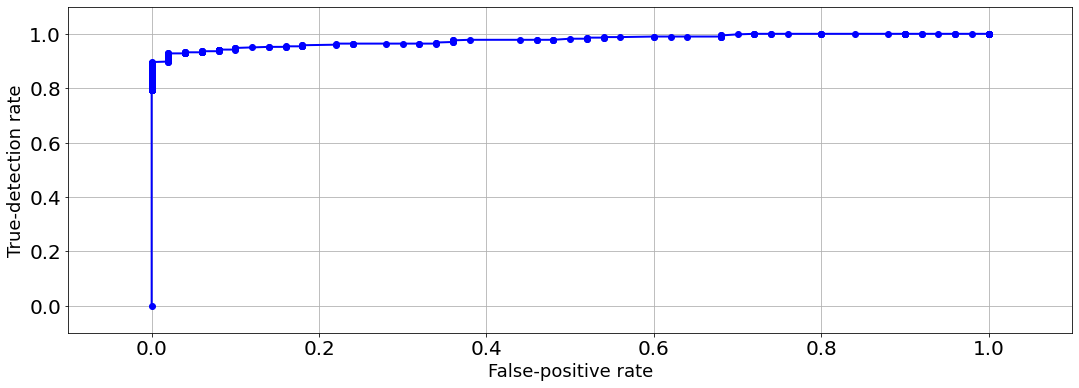

In [51]:
# These values can be changed
n1 = 100
n2 = 5000

false_pos = np.zeros(n2)
true_detec = np.zeros(n2)

for ii in range(0,n2):
  thresh_0 = np.linspace(0,n1,n2)
  y = Disthv_dist

  decis_h = 1*(y > thresh_0[ii])
  false_pos[ii] = np.sum(decis_h)/len(decis_h)

  yd1 = Distd_dist_D1
  yd2 = Distd_dist_D2
  yd3 = Distd_dist_D3
  yd4 = Distd_dist_D4
  yd5 = Distd_dist_D5

  decis_d1 = 1*(yd1 > thresh_0[ii])
  decis_d2 = 1*(yd2 > thresh_0[ii])
  decis_d3 = 1*(yd3 > thresh_0[ii])
  decis_d4 = 1*(yd4 > thresh_0[ii])
  decis_d5 = 1*(yd5 > thresh_0[ii])

  true_detec[ii] = np.sum(np.array([decis_d1,decis_d2,decis_d3,decis_d4,decis_d5]))/(5*len(decis_d1))

false_pos[-1] = 0
true_detec[-1] = 0

# area under curve
auc = np.trapz(y=true_detec, x=false_pos)

print('')
print('Area Under Curve (AUC): {:.2f}'.format(np.sqrt(auc**2)))

plt.figure(figsize=(18,6))
plt.plot(false_pos,true_detec, 'bo-', linewidth=2)
plt.ylabel('True-detection rate',fontsize=18)
plt.ylim([-0.1, 1.1])
plt.xlim([-0.1, 1.1])
plt.xlabel('False-positive rate',fontsize=18)
plt.grid()
plt.show()

# 6. Find the less loss of stiffness that your algorithm can detect with a probability of detection of 95% and less than 5% of false alarm. Show a plot of the loss of stiffness with the probability of detection.

A partir deste item, serão refeitos os passos anteriores, mas em **B)** sem considerar o índice $\gamma_{AR}$ como *feature* e em **C)** considerando-o como *feature*.

Probability of detection = Recall

In [52]:
k_0 = 1000    # [N/m]
m = 1         # [kg]

Fs = 10*Fn                     # sampling frequency (Hz)
dt = 1/Fs                      # time period (s)
N = 8*1024;                    # number of samples
t = np.arange(0,N*dt,dt)       # time vector

kd = np.arange(99.9,80,-0.5)*0.01*k_0     # reduction
Rep = 100
yh = np.zeros((Rep,N))
yd = np.zeros((Rep,N,len(kd)))
Yd = np.zeros((Rep,np.int(N/8)+1,len(kd)))

for k in range(0,Rep):
    
    u = np.random.randn(N,1)
    yh[k,:] = signal.lsim(H,u,t)[1];       # healthy state
 
    for i in range(0, len(kd)):
      
        Hd = signal.TransferFunction(1,[m, 0, kd[i]]);                         # damage model
        u = np.random.randn(N,1);                                              # random excitation (N)
        yd[k,:,i] = signal.lsim(Hd,u,t)[1]
        
        freq, aux = welch(yd[k,:,i], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)

        #[aux,freq] = pwelch(squeeze(yd(k,:,i)),hanning(N/4),N/8,N/4,Fs);       # healthy state
        Yd[k,:,i] = aux
        sys.stdout.flush()
        sys.stdout.write("\rProgress: {} %".format((k/(Rep-1)*100)))

Progress: 100.0 %9898989899 %%

In [53]:
y = signal.lsim(H,u,t);        # displacement (m)
freq, Y = welch(y[1], Fs, window=hanning(np.int(N/4), True), noverlap=N/8, nfft=N/4, return_onesided=True)

Em toda a análise dos Casos **B)** e **C)**, as legendas D1, D2, D3, D4 e D5 correspondem, respectivamente, às porcentagens de perda de rigidez de 0.5%, 5%, 10%, 15% e 19%.

**Variação da frequência natural com a diminuição do valor da rigidez.**
Observa-se que conforme ocorre a perda de rigidez, uma vez que a frequência natural é calculada por $\omega_n=\sqrt{k/m}$, tem-se o deslocamento para a esquerda, conforme mostra o gráfico.

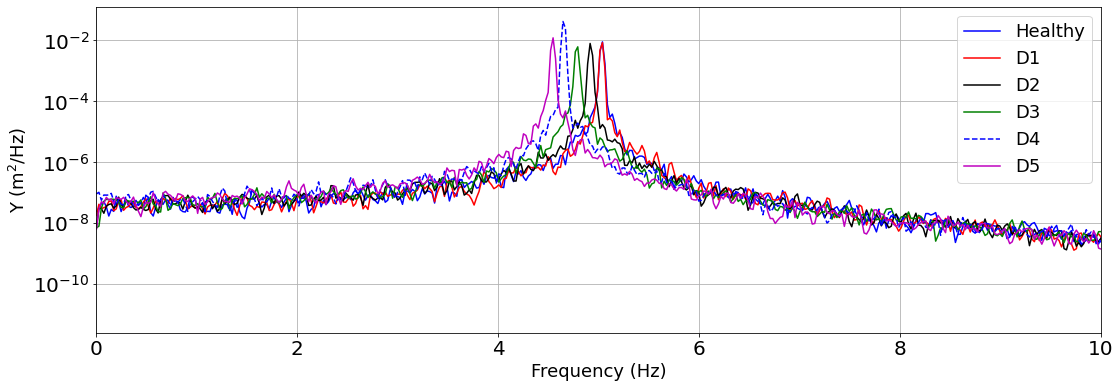

In [54]:
plt.figure(figsize=(18,6))
plt.plot(freq,Y,'b',label='Healthy')
plt.plot(freq,Yd[50,:,1-1],'r',label='D1')
plt.plot(freq,Yd[50,:,10-1],'k',label='D2')
plt.plot(freq,Yd[50,:,20-1],'g',label='D3')
plt.plot(freq,Yd[50,:,30-1],'b--',label='D4')
plt.plot(freq,Yd[50,:,38-1],'m',label='D5')
plt.yscale('log')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Y (m$^2$/Hz)',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()
plt.xlim([0,10])
plt.show()

# Proposed and extract a list of possible features from these vibration signals to label the structural state. Compare the performance of both to decide what is the best combination to compute a damage index.

**Compute a feature - variance of displacement**

In [55]:
from scipy.stats import norm, kurtosis

In [56]:
reference = np.var(y[1]) 

Ih = np.zeros((Rep,1))
I1h = np.zeros((Rep,1))
I2h = np.zeros((Rep,1))
Gammah = np.zeros((Rep,1))

Id = np.zeros((len(kd),Rep))
I1d = np.zeros((len(kd),Rep))
I2d = np.zeros((len(kd),Rep))
Gammad = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    
    Ih[k] = np.var(yh[k,:])
    I1h[k] = kurtosis(yh[k,:])
    I2h[k] = np.linalg.norm(yh[k,:])
    Gammah[k] = Ih[k]/reference
    
    for i in range(0,len(kd)):
        
      Id[i,k] = np.var(yd[k,:,i])
      I1d[i,k] = kurtosis(yd[k,:,i])
      I2d[i,k] = np.linalg.norm(yd[k,:,i])
      Gammad[i,k] = Id[i,k]/reference

**Box features**

**Variance**

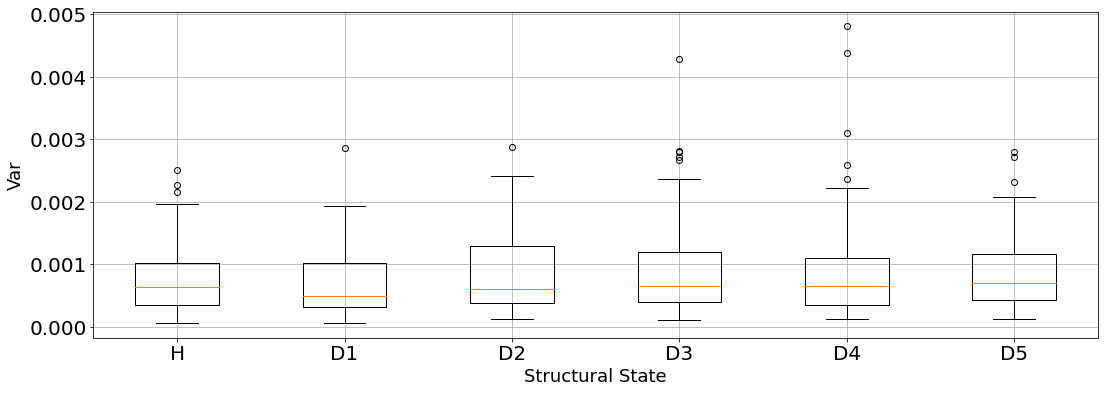

In [57]:
# Variance
plt.figure(figsize=(18,6))
plt.boxplot([Ih[:,0].T, Id[1-1,:], Id[10-1,:], Id[20-1,:], Id[30-1,:], Id[38-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('Var',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Kurtosis**

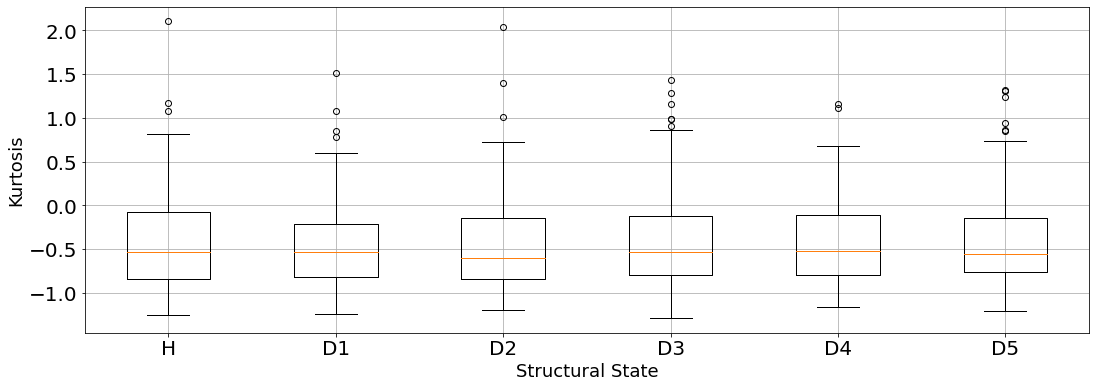

In [58]:
# Kurtosis
plt.figure(figsize=(18,6))
plt.boxplot([I1h[:,0].T, I1d[1-1,:], I1d[10-1,:], I1d[20-1,:], I1d[30-1,:], I1d[38-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('Kurtosis',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**2-Norm**

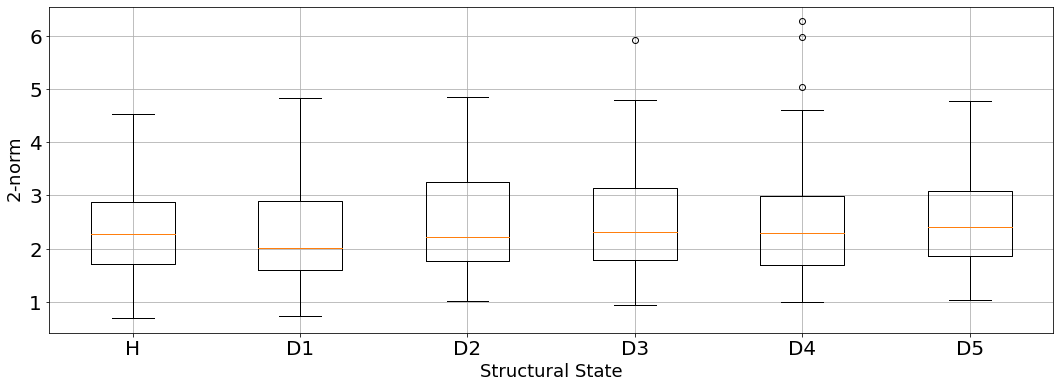

In [59]:
# 2-Norm
plt.figure(figsize=(18,6))
plt.boxplot([I2h[:,0].T, I2d[1-1,:], I2d[10-1,:], I2d[20-1,:], I2d[30-1,:], I2d[38-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$2$-norm',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Space of features**

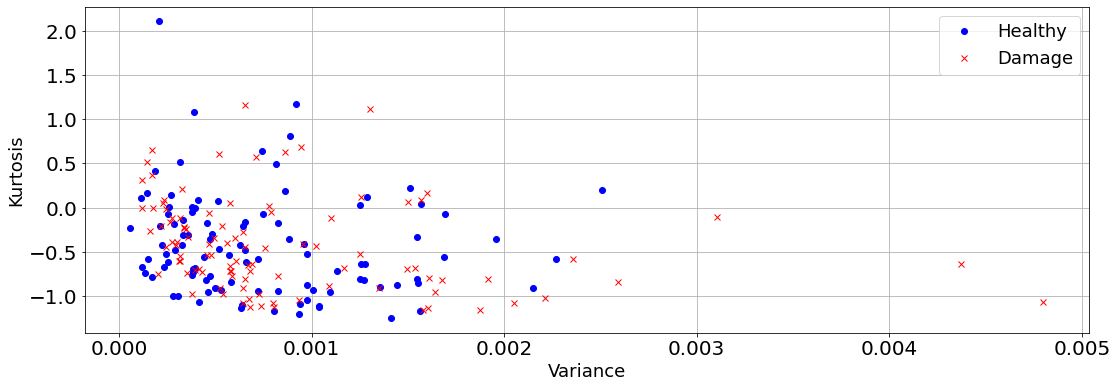

In [60]:
plt.figure(figsize=(18,6))
plt.plot(Ih,I1h,'ob',label='Healthy')
plt.plot(Id[30-1,:],I1d[30-1,:],'xr',label='Damage')
plt.legend(loc='best',fontsize=18)
plt.grid()
plt.xlabel('Variance',fontsize=18)
plt.ylabel('Kurtosis',fontsize=18)
plt.show()

**Gamma**

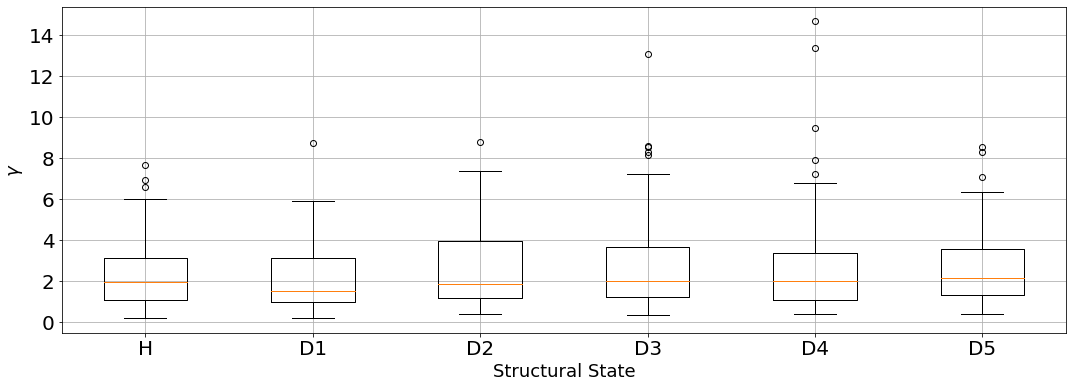

In [61]:
# Gamma
plt.figure(figsize=(18,6))
plt.boxplot([Gammah[:,0].T, Gammad[1-1,:], Gammad[10-1,:], Gammad[20-1,:], Gammad[30-1,:], Gammad[38-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$\gamma$',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**Extracting Natural Frequency**



In [62]:
# Healthy state

FeatWh = np.zeros((Rep,1))
FeatW = np.zeros((Rep,len(kd)))

for k in range(0,Rep):
  FeatWh[k] = Fn + 0.01*np.random.randn(1)*Fn

# Damage
for k in range(0,Rep):   
    for i in range(0,len(kd)):
        for j in range(0,len(freq)):
            if Yd[k,j,i]==np.max(Yd[k,:,i]):
              FeatW[k,i]= freq[j]+0.01*np.random.randn(1)*freq[j]

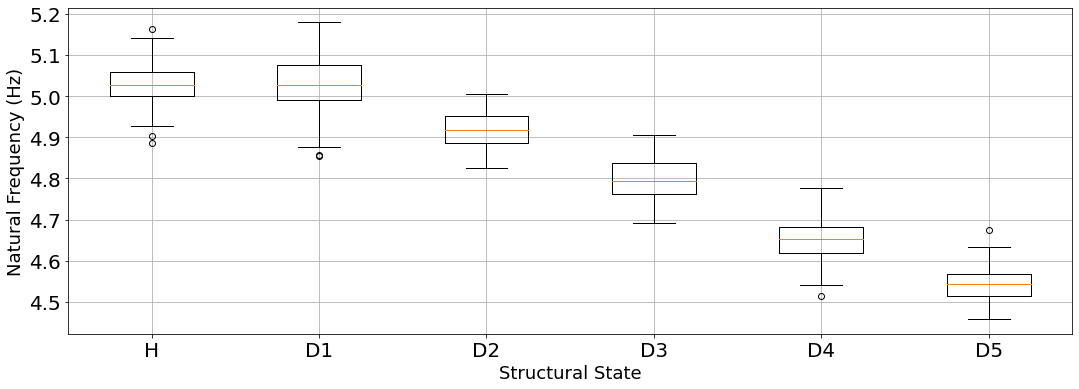

In [63]:
# Natural Frequency
plt.figure(figsize=(18,6))
plt.boxplot([np.transpose(FeatWh[:,0]), np.transpose(FeatW[:,1-1]), np.transpose(FeatW[:,10-1]),
             np.transpose(FeatW[:,20-1]), np.transpose(FeatW[:,30-1]), np.transpose(FeatW[:,38-1])],labels=['H','D1','D2','D3','D4','D5'])
plt.grid()
plt.xlabel('Structural State',fontsize=18)
plt.ylabel('Natural Frequency (Hz)',fontsize=18)
plt.show()

**RMSE from signals in time domain**

In [64]:
rmseh = np.zeros((Rep,1))
rmsed = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    rmseh[k] = np.linalg.norm(yh[k,:] - y[1]) / np.sqrt(len(y[1]))

    for i in range(0,len(kd)):
      rmsed[i,k] = np.linalg.norm(yd[k,:,i] - y[1]) / np.sqrt(len(y[1]))

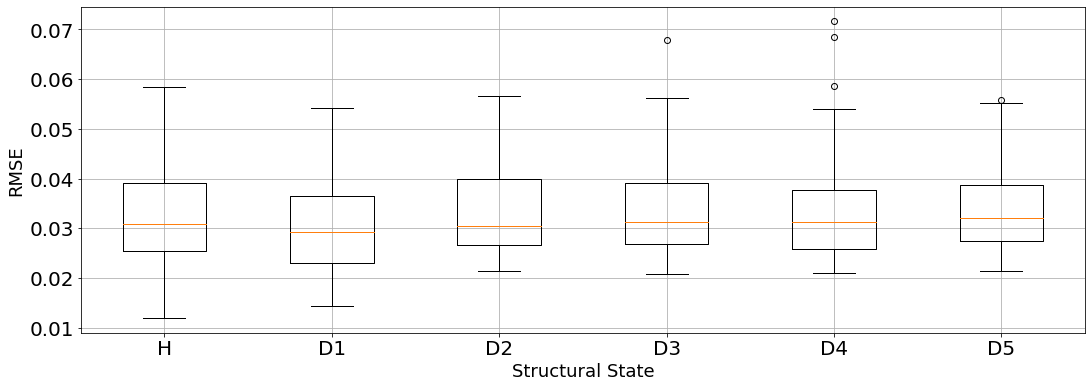

In [65]:
# RMSE
plt.figure(figsize=(18,6))
plt.boxplot([rmseh[:,0].T, rmsed[1-1,:], rmsed[10-1,:], rmsed[20-1,:], rmsed[30-1,:], rmsed[38-1,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('RMSE',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.show()

**AR Model**

In [66]:
from statsmodels.tsa.ar_model import AutoReg

In [67]:
import warnings
warnings.filterwarnings('ignore')

order = 20  # order model
akaike = np.zeros((order,1))
nt = np.random.randint(0, Rep-1)

for i in range(1,order):
    model = AutoReg(yh[nt,:], lags=i).fit()         # AR model
    akaike[i] = model.aic                              # Akaike's Information Criterion 

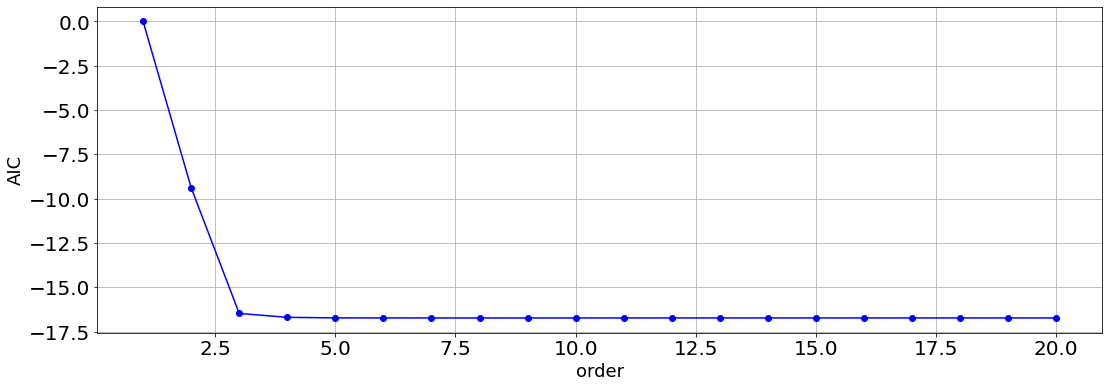

In [68]:
plt.figure(figsize=(18,6))
plt.plot(np.arange(1,order+1,1),akaike,'ob-')
plt.xlabel('order',fontsize=18)
plt.ylabel('AIC',fontsize=18)
plt.grid()
plt.show()

**Escolha da ordem igual a 4 segundo o critério de Akaike**

In [69]:
na = 4                                      # order
nt = np.random.randint(0, Rep-1)
model_h = AutoReg(yh[nt,:],lags=na).fit();  # reference model
print(model_h.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 8192
Model:                     AutoReg(4)   Log Likelihood               56717.629
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sat, 08 May 2021   AIC                            -16.690
Time:                        15:08:49   BIC                            -16.685
Sample:                             4   HQIC                           -16.688
                                 8192                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.233e-06   2.62e-06      0.470      0.638   -3.91e-06    6.37e-06
y.L1           2.1585      0.011    199.216      0.000       2.137       2.180
y.L2          -2.0719      0.024    -84.857      0.0

In [70]:
a_0 = model_h.params[0]
a_1 = model_h.params[1]
a_2 = model_h.params[2]
a_3 = model_h.params[3]
a_4 = model_h.params[4]

**Predição do modelo - saudável e com dano**

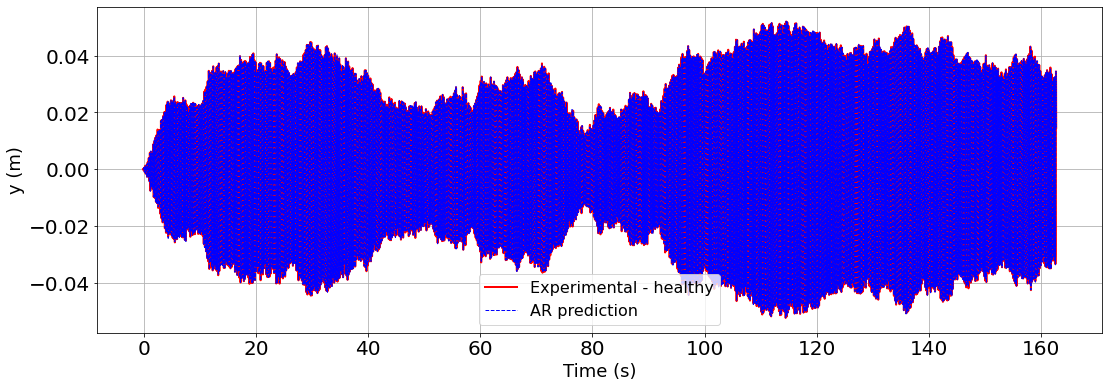

In [71]:
yp = np.zeros((len(t)-na,1))
e_ref = np.zeros((len(t)-na,1))
cont_ = na

for cont in range(0,len(t)-na):
    yp[cont] = a_0 + a_1*yh[nt,cont_-1] + a_2*yh[nt,cont_-2] + a_3*yh[nt,cont_-3] + a_4*yh[nt,cont_-4]
    e_ref[cont] = (yp[cont] - yh[nt,cont+na])**2
    cont_ += 1

Ref = np.var(e_ref)  
    
plt.figure(figsize=(18,6))
plt.plot(t-t[na],yh[nt,:],'r',linewidth=2,label='Experimental - healthy')
plt.plot(t[0:-na],yp,'b--',linewidth=1,label='AR prediction')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.grid()
#plt.xlim([0,5])
plt.legend(loc='best',fontsize=16)
plt.show()

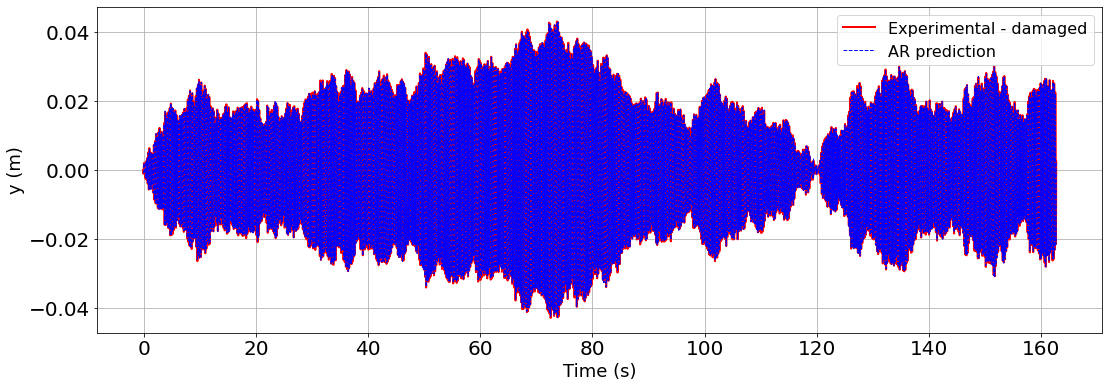

In [72]:
yp = np.zeros((len(t)-na,1))
nt = np.random.randint(0, Rep-1)
nt_ = np.random.randint(0, len(kd)-1)
e_dam = np.zeros((len(t)-na,1))
cont_ = na

for cont in range(0,len(t)-na):
    yp[cont] = a_0 + a_1*yd[nt,cont_-1,nt_] + a_2*yd[nt,cont_-2,nt_] + a_3*yd[nt,cont_-3,nt_] + a_4*yd[nt,cont_-4,nt_]
    e_dam[cont] = (yp[cont] - yd[nt,cont+na,nt_])**2
    cont_ += 1

plt.figure(figsize=(18,6))
plt.plot(t-t[na],yd[nt,:,nt_],'r',linewidth=2,label='Experimental - damaged')
plt.plot(t[0:-na],yp,'b--',linewidth=1,label='AR prediction')
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('y (m)',fontsize=18)
plt.grid()
#plt.xlim([50,55])
plt.legend(loc='best',fontsize=16)
plt.show()

**Distribuição do erro (histograma)**

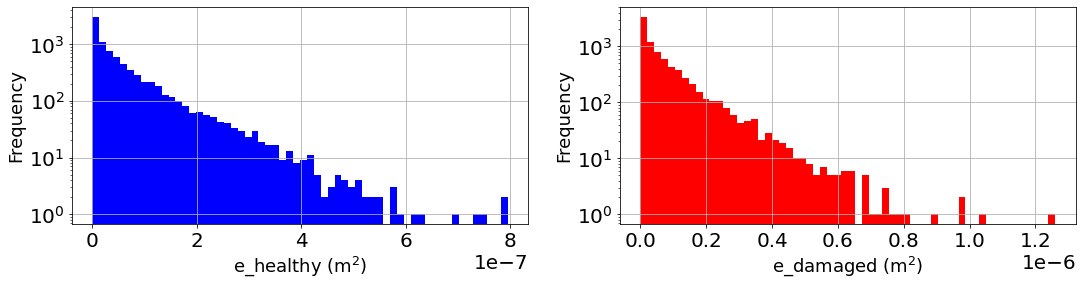

In [73]:
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
plt.hist(e_ref,bins=60,color='blue')
plt.xlabel('e_healthy (m$^2$)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.yscale('log')
plt.grid()

plt.subplot(1,2,2)
plt.hist(e_dam,bins=60,color='red')
plt.xlabel('e_damaged (m$^2$)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.yscale('log')
plt.grid()

plt.show()

**Cálculo do índice $\gamma_{AR}$.**

In [74]:
erro_h = np.zeros((Rep,1))
Gammah_AR = np.zeros((Rep,1))

erro_d = np.zeros((len(kd),Rep))
Gammad_AR = np.zeros((len(kd),Rep))

for k in range(0,Rep):
    cont_ = na
    e_h = np.zeros((len(t)-na,1))
    yp = np.zeros((len(t)-na,1))
    
    for cont in range(0,len(t)-na):
        yp[cont] = a_0 + a_1*yh[k,cont_-1] + a_2*yh[k,cont_-2] + a_3*yh[k,cont_-3] + a_4*yh[k,cont_-4]
        e_h[cont] = (yp[cont] - yh[k,cont+na])**2
        cont_ += 1
    
    erro_h[k] = np.var(e_h)
    Gammah_AR[k] = erro_h[k] / Ref
        
    for i in range(0,len(kd)):
        
            cont_ = na
            e_d = np.zeros((len(t)-na,1))
            yp_ = np.zeros((len(t)-na,1))
            
            for cont in range(0,len(t)-na):
                yp_[cont] = a_0 + a_1*yd[k,cont_-1,i] + a_2*yd[k,cont_-2,i] + a_3*yd[k,cont_-3,i] + a_4*yd[k,cont_-4,i]
                e_d[cont] = (yp_[cont] - yd[k,cont+na,i])**2
                cont_ += 1
        
            erro_d[i,k] = np.var(e_d)
            Gammad_AR[i,k] = erro_d[i,k] / Ref
            
    sys.stdout.flush()
    sys.stdout.write("\rProgress: {} %".format((k/(Rep-1)*100)))

Progress: 100.0 %9898989899 %%

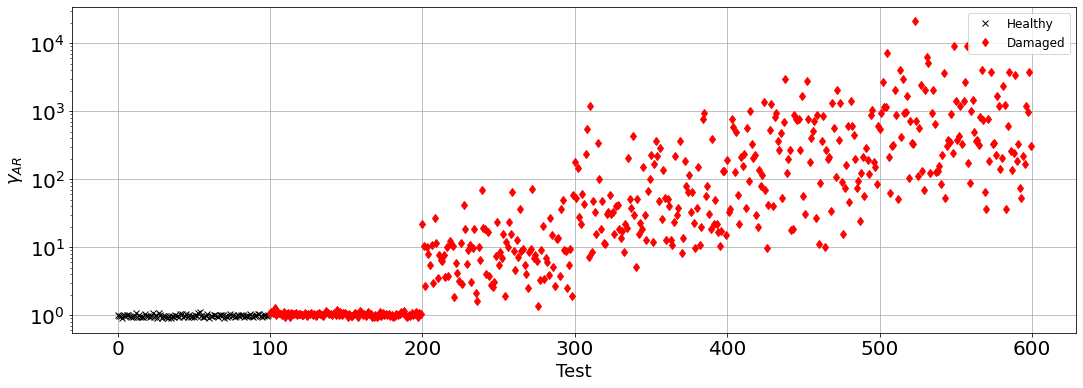

In [75]:
plt.figure(figsize=(18,6))
plt.plot(np.arange(0,100,1),Gammah_AR, 'xk',label='Healthy')
plt.plot(np.arange(100,200,1),Gammad_AR[1,:],'dr',label='Damaged')
plt.plot(np.arange(200,300,1),Gammad_AR[10,:],'dr')
plt.plot(np.arange(300,400,1),Gammad_AR[20,:],'dr')
plt.plot(np.arange(400,500,1),Gammad_AR[30,:],'dr')
plt.plot(np.arange(500,600,1),Gammad_AR[38,:],'dr')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$\gamma_{AR}$',fontsize=18)
plt.grid()
plt.show()

**Boxplot do índice $\gamma_{AR}$**

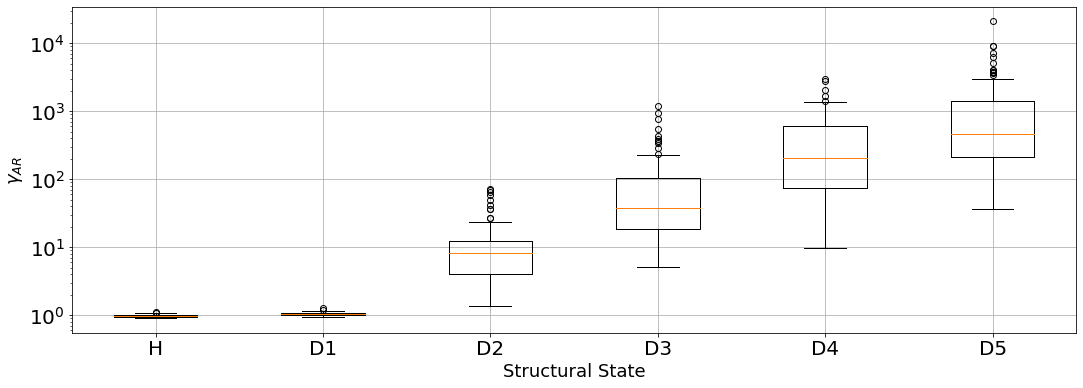

In [76]:
# Gamma_AR
plt.figure(figsize=(18,6))
plt.boxplot([Gammah_AR[:,0].T, Gammad_AR[1,:], Gammad_AR[10,:], Gammad_AR[20,:], Gammad_AR[30,:], Gammad_AR[38,:]],labels=['H','D1','D2','D3','D4','D5'])
plt.ylabel('$\gamma_{AR}$',fontsize=18) 
plt.xlabel('Structural State',fontsize=18)
plt.grid()
plt.yscale('log')
plt.show()

**Space of features**

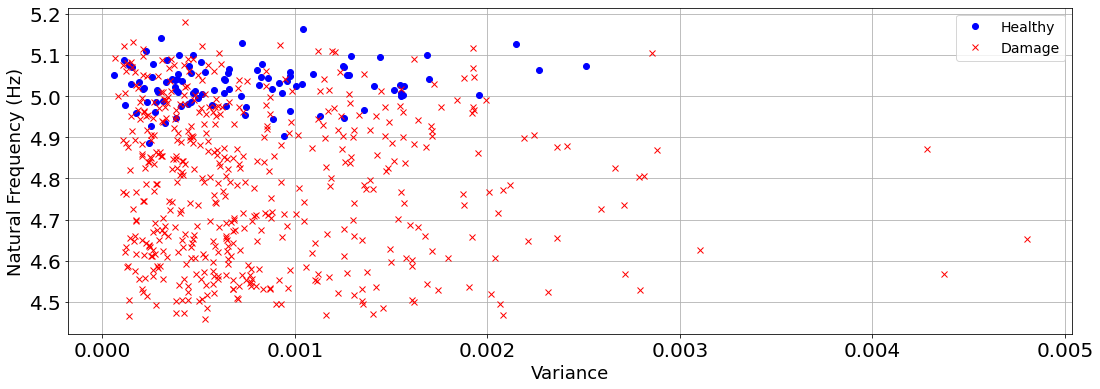

In [77]:
plt.figure(figsize=(18,6))
plt.plot(Ih,FeatWh,'ob',label='Healthy')
plt.plot(Id[1-1,:], FeatW[:,1-1],'xr',label='Damage')
plt.plot(Id[10-1,:], FeatW[:,10-1],'xr')
plt.plot(Id[20-1,:], FeatW[:,20-1],'xr')
plt.plot(Id[30-1,:], FeatW[:,30-1],'xr')
plt.plot(Id[38-1,:], FeatW[:,38-1],'xr')
plt.legend(loc='best',fontsize=14)
plt.xlabel('Variance',fontsize=18)
plt.ylabel('Natural Frequency (Hz)',fontsize=18)
plt.grid()
plt.show()

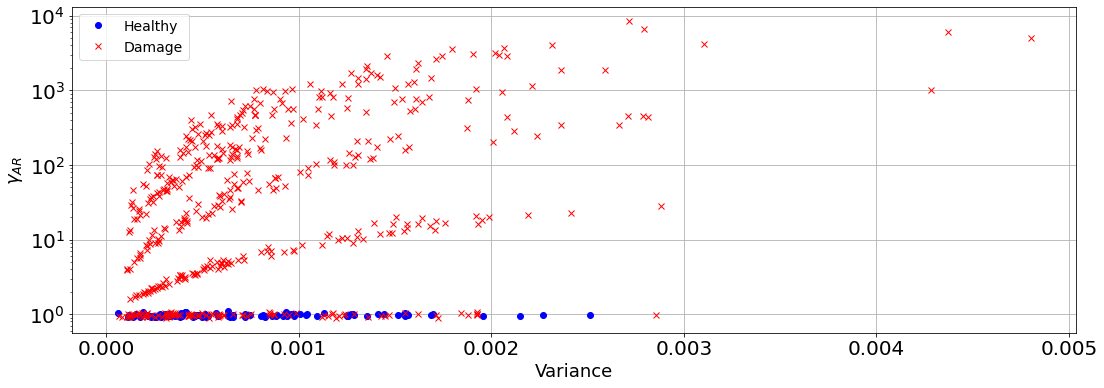

In [78]:
plt.figure(figsize=(18,6))
plt.plot(Ih,Gammah_AR[:,0].T,'ob',label='Healthy')
plt.plot(Id[1-1,:], Gammad_AR[1-1,:],'xr',label='Damage')
plt.plot(Id[10-1,:], Gammad_AR[10-1,:],'xr')
plt.plot(Id[20-1,:], Gammad_AR[20-1,:],'xr')
plt.plot(Id[30-1,:], Gammad_AR[30-1,:],'xr')
plt.plot(Id[38-1,:], Gammad_AR[38-1,:],'xr')
plt.legend(loc='best',fontsize=14)
plt.xlabel('Variance',fontsize=18)
plt.ylabel('$\gamma_{AR}$',fontsize=18)
plt.yscale('log')
plt.grid()
plt.show()

# Caso B)

**Learning features**

In [79]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]

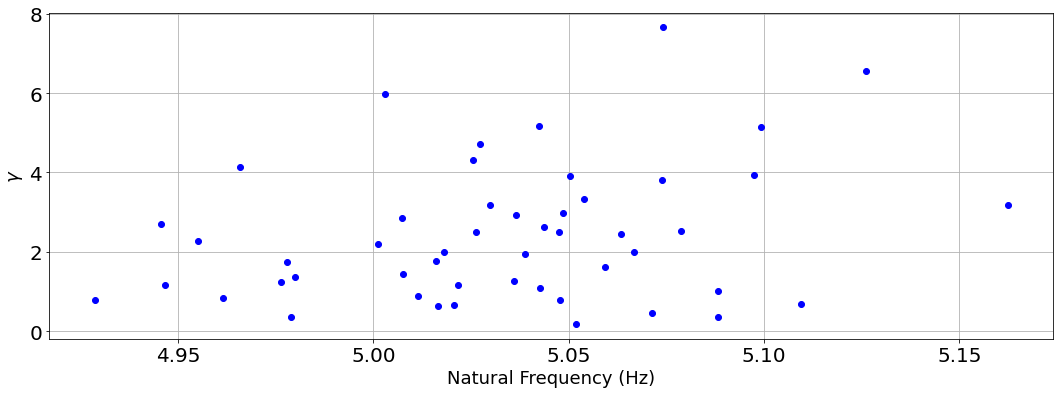

In [80]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]
valida = observation[np.int(np.round(0.5*Rep)):Rep]

# Learning data
Xh = np.transpose(FeatWh[learn])
Yh = np.transpose(Gammah[learn])

plt.figure(figsize=(18,6))
plt.plot(Xh,Yh,'bo')
plt.xlabel('Natural Frequency (Hz)',fontsize=18)
plt.ylabel('$\gamma$',fontsize=18)
plt.grid()
plt.show()

**Validation data - healthy state**

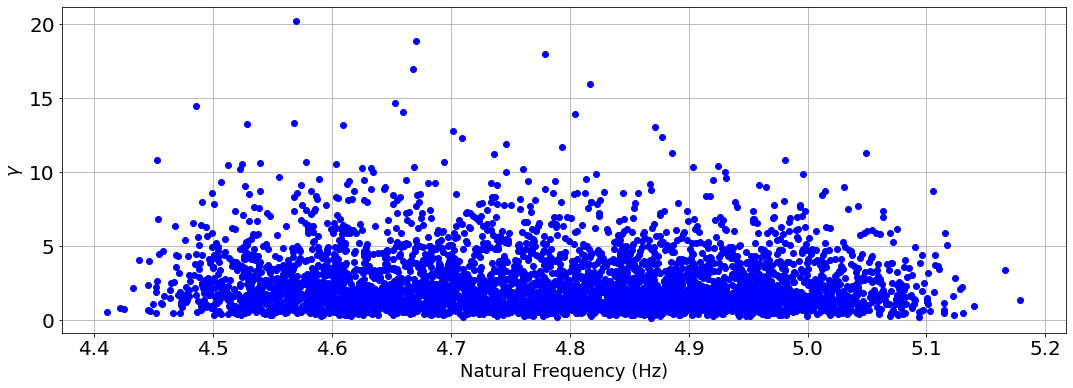

In [81]:
Xhv = np.transpose(FeatWh[valida])
Yhv = np.transpose(Gammah[valida])

# Validation data - damaged state

F = np.zeros((len(Gammad),len(Gammad[0])))
G = np.zeros((len(Gammad),len(Gammad[0])))

for i in range(0,len(Gammad)):
  G[i,:] = Gammad[i,:]   #np.array([Gammad[1,:], Gammad[10,:], Gammad[20,:], Gammad[30,:], Gammad[38,:]])
  F[i,:] = FeatW[:,i]  #np.array([FeatW[:,1], FeatW[:,10], FeatW[:,20], FeatW[:,30], FeatW[:,38]])

plt.figure(figsize=(18,6))
plt.plot(Xhv, Yhv, 'bo')
plt.plot(F,G,'bo')
plt.ylabel('$\gamma$',fontsize=18); 
plt.xlabel('Natural Frequency (Hz)',fontsize=18); 
plt.grid()
plt.show()

# Determine the Mahalanobis square distance using half sample of the healthy data as learning data and healthy data and all damaged data to validate. Perform it randomly, assuming a variable number of samples for learning (training) and validate (testing).

**Learning a statistical model**

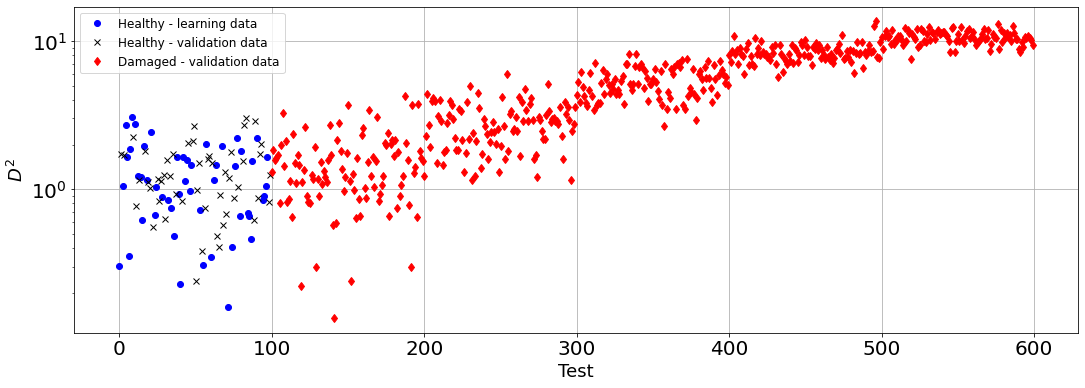

In [82]:
Disth = Mahalanobis(np.concatenate([Xh,Yh],axis=0).T,2*len(Xh[0]))
Disth_dist = Disth.calc_distances(np.concatenate([Xh,Yh],axis=0).T)              # learning

Disthv = Mahalanobis(np.concatenate([Xh,Yh],axis=0).T,2*len(Xh[0]))
Disthv_dist = Disthv.calc_distances(np.concatenate([Xhv,Yhv],axis=0).T)          # healthy validation

Distd = Mahalanobis(np.concatenate([Xh,Yh],axis=0).T,2*len(Xh[0]))

Distd_dist_Di = np.zeros((len(F),len(Xh[0])+len(Xhv[0])))

for ii in range(0,len(F)):
  Distd_dist_Di[ii,:] = Distd.calc_distances(np.concatenate([F,G],axis=0)[[ii,ii+len(F)],:].T).T # damaged validation

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 4. Compute the threshold value to a binary classification (healthy or damaged state) using at least two approaches.

**Threshold**

**Using np.max()**

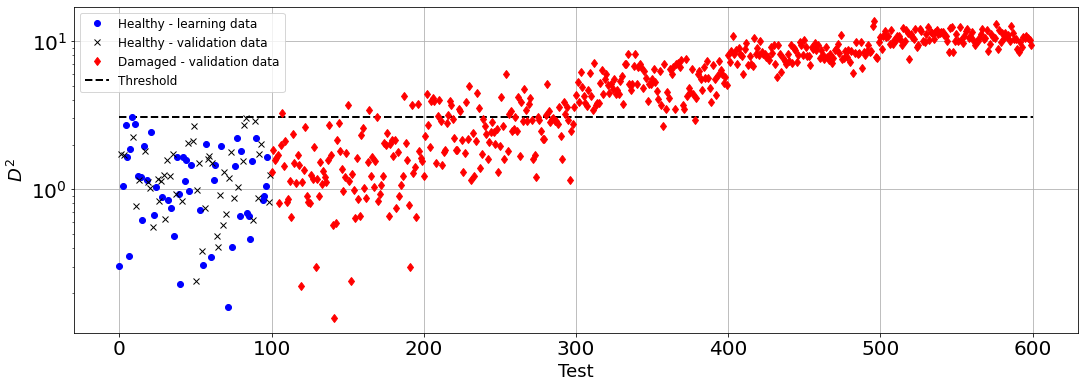

In [83]:
plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(np.max(Disth_dist),0,600,color='black',linestyle='--',linewidth=2,label='Threshold')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

**Chi-Square**

Aqui usando graus de liberdade = dimensão de $D^2$, nesse caso 2.

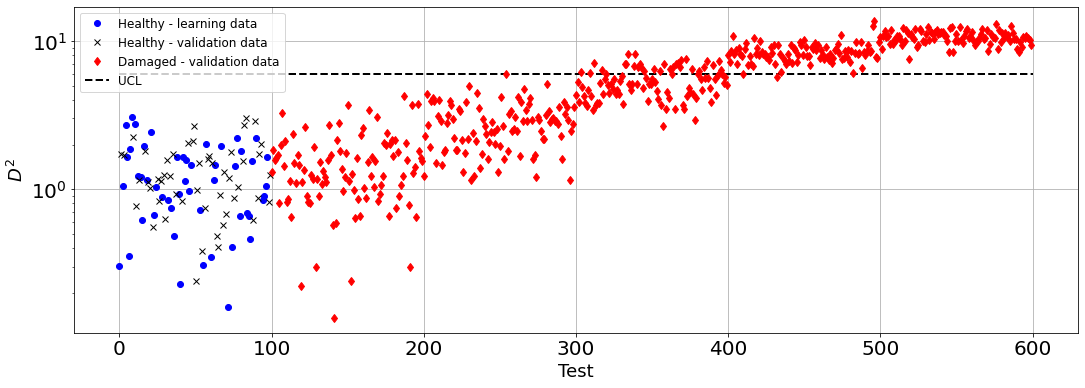

In [84]:
from scipy.stats.distributions import chi2

PFA = 0.05
m = len(Disth_dist)                     # same the number of observation in the learning data
degFreedom = 2
UCL_chi2 = chi2.ppf(1-PFA, df=degFreedom)

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(UCL_chi2,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

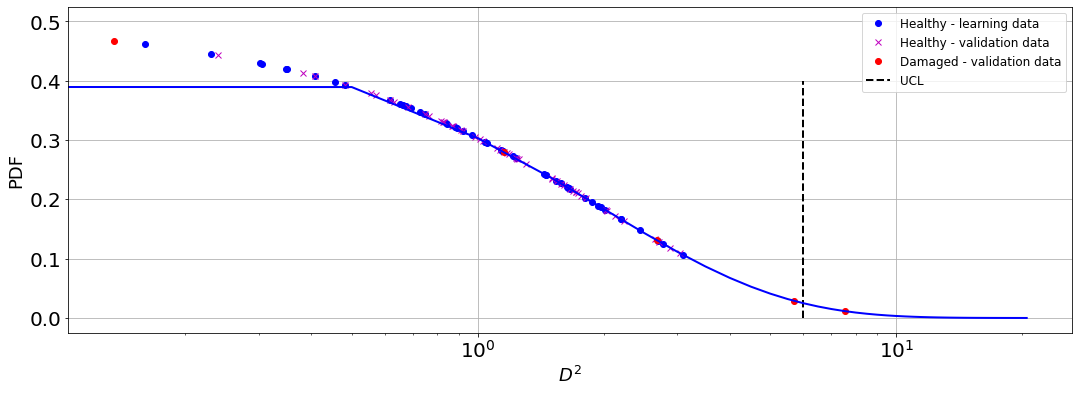

In [85]:
degf = 2
pdf = chi2.pdf(Disth_dist,degf)
pdfv = chi2.pdf(Disthv_dist,degf)
pdfd1 = chi2.pdf(np.min(Distd_dist_Di[0,:]),degf)
pdfd2 = chi2.pdf(np.min(Distd_dist_Di[10-1,:]),degf)
pdfd3 = chi2.pdf(np.min(Distd_dist_Di[20-1,:]),degf)
pdfd4 = chi2.pdf(np.min(Distd_dist_Di[30-1,:]),degf)
pdfd5 = chi2.pdf(np.min(Distd_dist_Di[38-1,:]),degf)

x = np.arange(0,21,0.5)
y4 = np.zeros(len(x))
for i in range(0,len(x)):
  y4[i] = chi2.pdf(x[i],degf)

plt.figure(figsize=(18,6))
plt.plot(Disth_dist, pdf, 'bo',label='Healthy - learning data')
plt.plot(Disthv_dist, pdfv, 'xm',label='Healthy - validation data')
plt.plot(np.min(Distd_dist_Di[0,:]),pdfd1,'or',label='Damaged - validation data')
plt.plot(np.min(Distd_dist_Di[10-1,:]),pdfd2,'or')
plt.plot(np.min(Distd_dist_Di[20-1,:]),pdfd3,'or')
plt.plot(np.min(Distd_dist_Di[30-1,:]),pdfd4,'or')
plt.plot(np.min(Distd_dist_Di[38-1,:]),pdfd5,'or')
plt.vlines(UCL_chi2,0,0.4,color='black',linestyle='--',linewidth=2,label='UCL')
plt.plot(x,y4,'b',linewidth=2)
plt.legend(loc='best',fontsize=12)
plt.xlabel('$D^2$',fontsize=18)
plt.ylabel('PDF',fontsize=18)
plt.grid()
plt.xscale('log')
plt.show()

**Using IQR Rule**

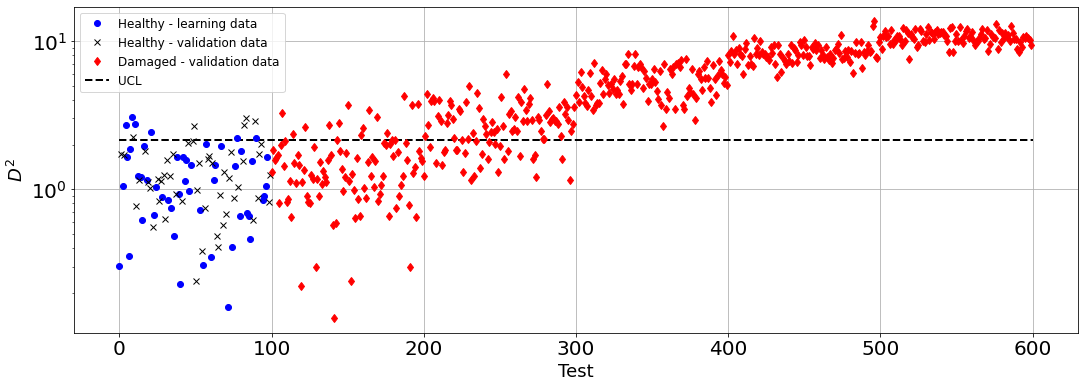

In [86]:
X = np.sort(Disth_dist)
M = np.median(Disth_dist)
X = np.sort(Disth_dist)

aux1 = []
aux2 = []

for i in range(1,len(Disth_dist)):
    if X[i]<M:
      aux1.append(X[i])    
    
    if X[i]>M:
      aux2.append(X[i])
    
Q1 = np.median(aux1) 
Q3 = np.median(aux2)
IQR = Q3-Q1
UCL_IRQ = Q1+1.5*IQR

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(UCL_IRQ,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 5. Compute the confusing matrix with the probability of detection and probability of false alarm. Show the ROC curve.

**Using np.max() as threshold**

In [87]:
import pandas as pd

FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_max = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>np.max(Disth_dist):
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<np.max(Disth_dist):
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_max[i] = TP/(TP+FN[i])

**Using chi-square**

In [88]:
FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_chi2 = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_chi2:
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<UCL_chi2:
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_chi2[i] = TP/(TP+FN[i])

**IQR**

In [89]:
FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_IRQ = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_IRQ:
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<UCL_IRQ:
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_IRQ[i] = TP/(TP+FN[i])

**ROC Curve**


Area Under Curve (AUC): 0.91


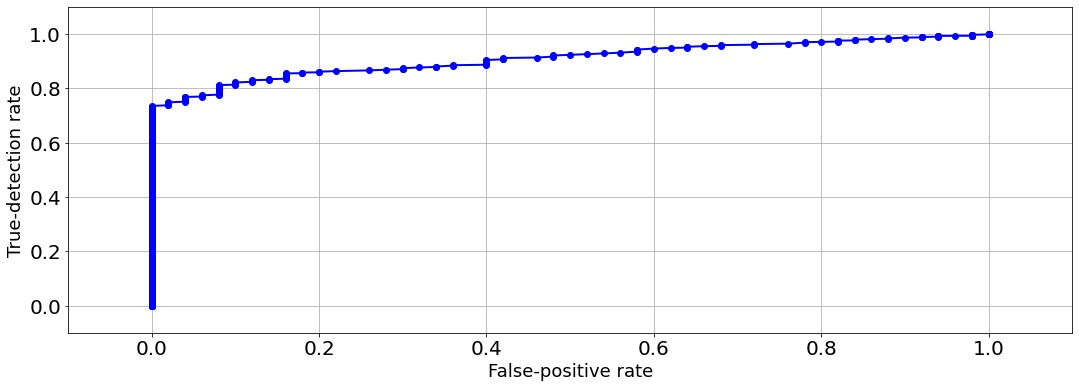

In [90]:
# These values can be changed
n1 = 100
n2 = 5000

false_pos = np.zeros(n2)
true_detec = np.zeros(n2)

decis_di = np.zeros((len(Distd_dist_Di),len(Distd_dist_Di[0])))

for ii in range(0,n2):
  thresh_0 = np.linspace(0,n1,n2)
  y = Disthv_dist

  decis_h = 1*(y > thresh_0[ii])
  false_pos[ii] = np.sum(decis_h)/len(decis_h)

  for j in range(0,len(Distd_dist_Di)):
      ydi = Distd_dist_Di[j]
      decis_di[j,:] = 1*(ydi > thresh_0[ii])

  true_detec[ii] = np.sum(decis_di)/(len(decis_di)*len(decis_di[0]))

# area under curve
auc = np.trapz(y=true_detec, x=false_pos)

print('')
print('Area Under Curve (AUC): {:.2f}'.format(np.sqrt(auc**2)))

plt.figure(figsize=(18,6))
plt.plot(false_pos,true_detec, 'bo-', linewidth=2)
plt.ylabel('True-detection rate',fontsize=18)
plt.ylim([-0.1, 1.1])
plt.xlim([-0.1, 1.1])
plt.xlabel('False-positive rate',fontsize=18)
plt.grid()
plt.show()

**Comparing Probability of Detection (or recall) and loss of stiffness**

Nesta etapa é feita uma comparação entre a métrica Recall (ou Probability of Detection), que é dada pela razão:

$PoD = \frac{TP}{TP + FN}$

onde:

$TP$: true positives

$FN$: false negatives

e que pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos, ou seja, dizer que a estrutura está em situação saudável quando está com dano é muito pior do que dizer que a mesma está com dano quando na verdade está saudável.

No gráfico abaixo, a ideia foi calcular o valor de Recall para cada situação e verificar qual o valor mínimo de rigidez que deve ser retirado para que a detecção não seja passível de erros (possíveis desastres). Obviamente que, não usando o índice $\gamma_{AR}$, maior porcentagem de rigidez deve ser retirada para um Recall de 100%, ou seja, sem Falsos Negativos. No Caso **C)**, entretanto, onde usamos o índice $\gamma_{AR}$, esse gráfico melhora consideravelmente.

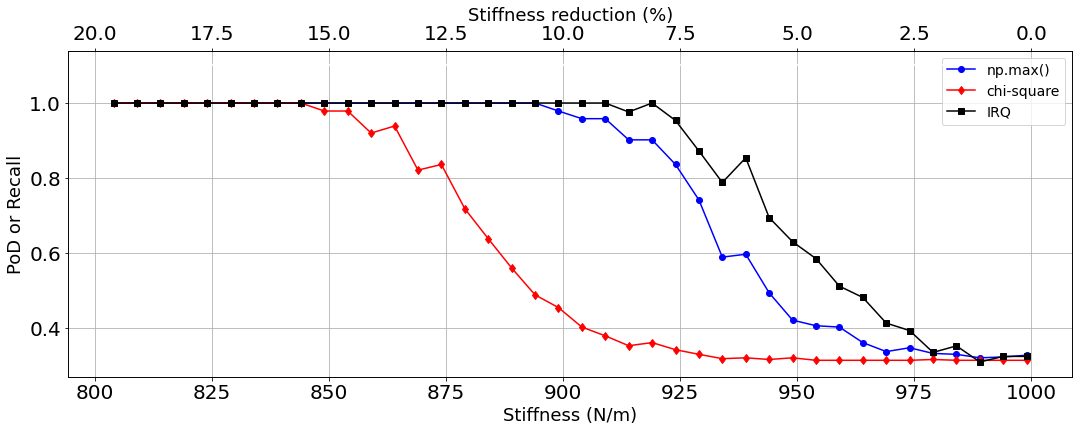

In [91]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(kd,recall_max,'bo-',label='np.max()')
ax1.plot(kd,recall_chi2,'dr-',label='chi-square')
ax1.plot(kd,recall_IRQ,'ks-',label='IRQ')
ax1.set_xlabel('Stiffness (N/m)',fontsize=18)
ax1.set_ylabel('PoD or Recall',fontsize=18)
ax2.plot(100-np.linspace((np.min(kd)/k_0),(np.max(kd)/k_0),len(kd))*100, 1.1*np.ones(len(kd)),'w-')
ax2.set_xlim(ax2.get_xlim()[::-1])
ax2.set_xlabel('Stiffness reduction (%)',fontsize=18)
#plt.ylim([0.1,1.05])
ax1.grid()
ax1.legend(loc='best',fontsize=14)
plt.show()

Nota-se a melhor abordagem (approach) para o threshold que requer menor porcentagem retirada de rigidez foi o Intervalo Interquartílico (IQR) ou IRQ como mostrado no gráfico, seguida do máximo (`np.max()`) e por último chi-square. Ainda assim, o mínimo valor de rigidez necessário para que a probabilidade de detecção (ou Recall) seja 100% é de pouco menos de 900 N/m aproximadamente (redução próxima de 10%).

# Caso C)

**Learning features**

In [92]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]

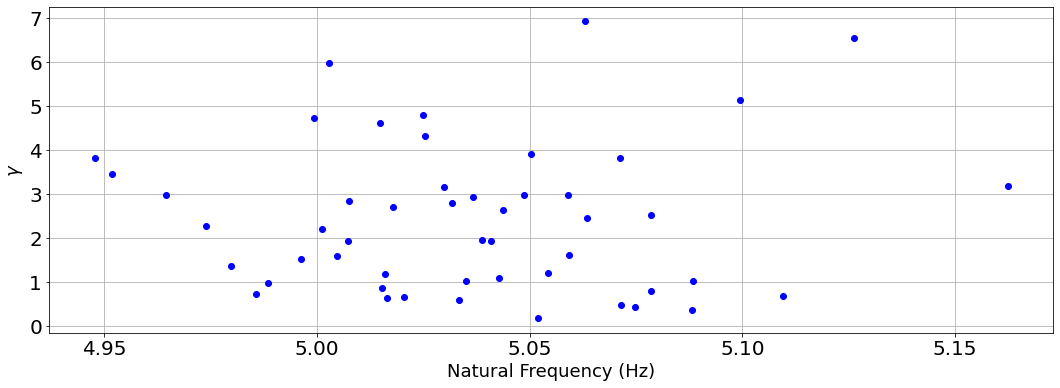

In [93]:
# Using 50% of data for learning and 50% for validation
observation = np.random.permutation(Rep)
learn = observation[0:np.int(np.round(0.5*Rep))]
valida = observation[np.int(np.round(0.5*Rep)):Rep]

# Learning data
Xh = np.transpose(FeatWh[learn])
Yh = np.transpose(Gammah[learn])
Zh = np.transpose(Gammah_AR[learn])

plt.figure(figsize=(18,6))
plt.plot(Xh,Yh,'bo')
plt.xlabel('Natural Frequency (Hz)',fontsize=18)
plt.ylabel('$\gamma$',fontsize=18)
plt.grid()
plt.show()

**Validation data - healthy state**

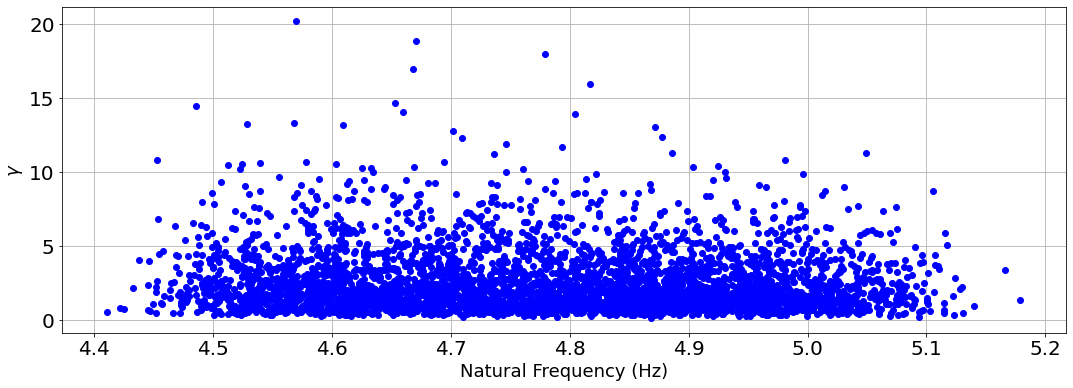

In [94]:
Xhv = np.transpose(FeatWh[valida])
Yhv = np.transpose(Gammah[valida])
Zhv = np.transpose(Gammah_AR[valida])

# Validation data - damaged state

F = np.zeros((len(Gammad),len(Gammad[0])))
G = np.zeros((len(Gammad),len(Gammad[0])))
E = np.zeros((len(Gammad_AR),len(Gammad_AR[0])))

for i in range(0,len(Gammad)):
  G[i,:] = Gammad[i,:] 
  F[i,:] = FeatW[:,i] 
  E[i,:] = Gammad_AR[i,:]  

plt.figure(figsize=(18,6))
plt.plot(Xhv, Yhv, 'bo')
plt.plot(F,G,'bo')
plt.ylabel('$\gamma$',fontsize=18); 
plt.xlabel('Natural Frequency (Hz)',fontsize=18); 
plt.grid()
plt.show()

# Determine the Mahalanobis square distance using half sample of the healthy data as learning data and healthy data and all damaged data to validate. Perform it randomly, assuming a variable number of samples for learning (training) and validate (testing).

**Learning a statistical model**

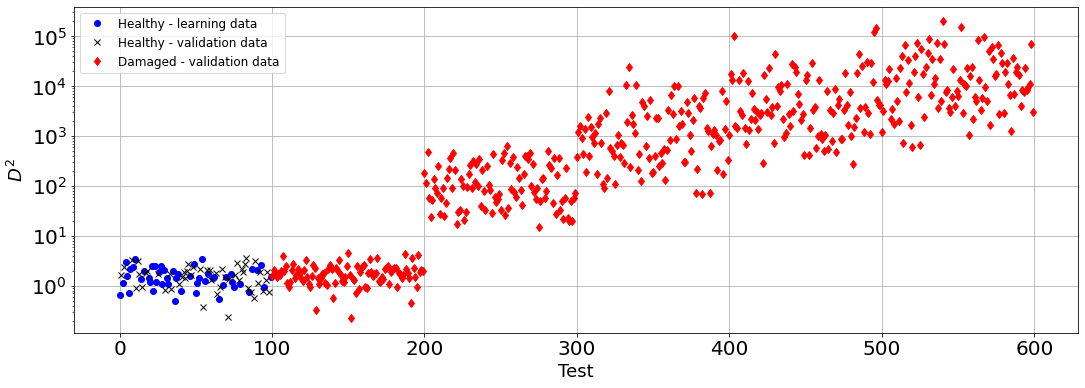

In [95]:
Disth = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))
Disth_dist = Disth.calc_distances(np.concatenate([Xh,Yh,Zh],axis=0).T)              # learning

Disthv = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))
Disthv_dist = Disthv.calc_distances(np.concatenate([Xhv,Yhv,Zhv],axis=0).T)          # healthy validation

Distd = Mahalanobis(np.concatenate([Xh,Yh,Zh],axis=0).T,2*len(Xh[0]))

Distd_dist_Di = np.zeros((len(F),len(Xh[0])+len(Xhv[0])))

for ii in range(0,len(F)):
  Distd_dist_Di[ii,:] = Distd.calc_distances(np.concatenate([F,G,E],axis=0)[[ii,ii+len(F),ii+2*len(F)],:].T).T # damaged validation

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 4. Compute the threshold value to a binary classification (healthy or damaged state) using at least two approaches.

**Threshold**

**Using np.max()**

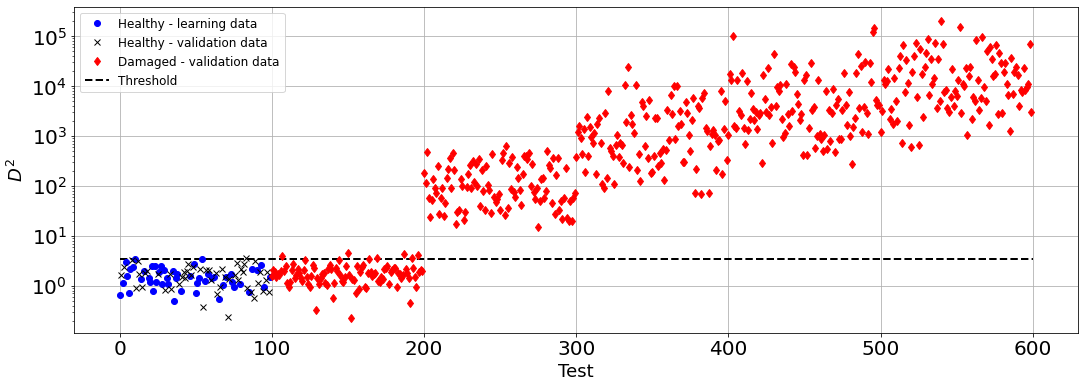

In [96]:
plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(np.max(Disth_dist),0,600,color='black',linestyle='--',linewidth=2,label='Threshold')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

**Chi-Square**

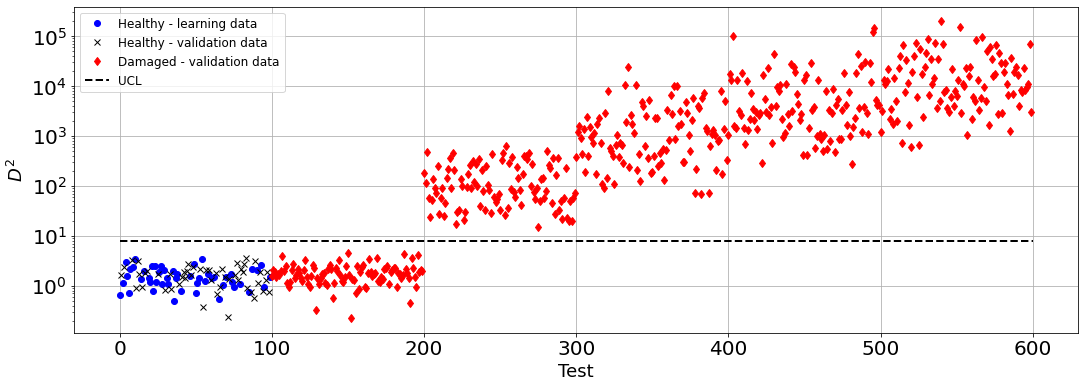

In [97]:
from scipy.stats.distributions import chi2

PFA = 0.05
m = len(Disth_dist)                     # same the number of observation in the learning data
degFreedom = 3
UCL_chi2 = chi2.ppf(1-PFA, df=degFreedom)

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(UCL_chi2,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

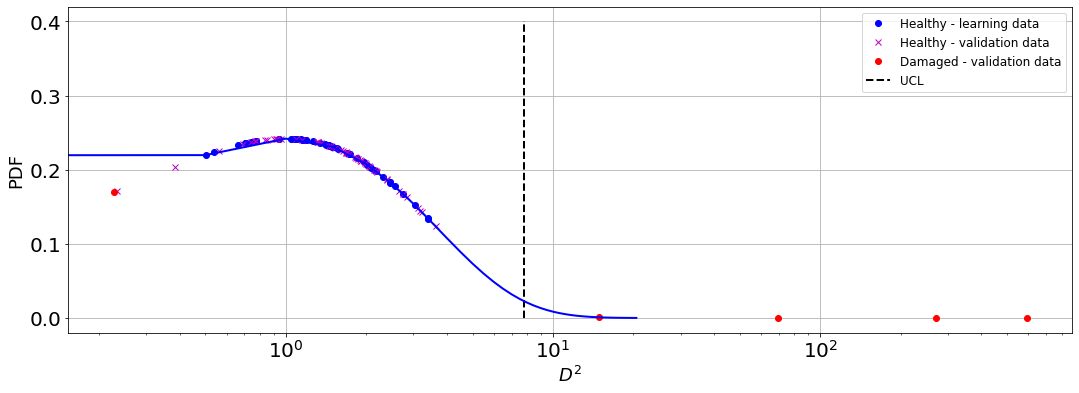

In [98]:
degf = 3
pdf = chi2.pdf(Disth_dist,degf)
pdfv = chi2.pdf(Disthv_dist,degf)
pdfd1 = chi2.pdf(np.min(Distd_dist_Di[0,:]),degf)
pdfd2 = chi2.pdf(np.min(Distd_dist_Di[10-1,:]),degf)
pdfd3 = chi2.pdf(np.min(Distd_dist_Di[20-1,:]),degf)
pdfd4 = chi2.pdf(np.min(Distd_dist_Di[30-1,:]),degf)
pdfd5 = chi2.pdf(np.min(Distd_dist_Di[38-1,:]),degf)

x = np.arange(0,21,0.5)
y4 = np.zeros(len(x))
for i in range(0,len(x)):
  y4[i] = chi2.pdf(x[i],degf)

plt.figure(figsize=(18,6))
plt.plot(Disth_dist, pdf, 'bo',label='Healthy - learning data')
plt.plot(Disthv_dist, pdfv, 'xm',label='Healthy - validation data')
plt.plot(np.min(Distd_dist_Di[0,:]),pdfd1,'or',label='Damaged - validation data')
plt.plot(np.min(Distd_dist_Di[10-1,:]),pdfd2,'or')
plt.plot(np.min(Distd_dist_Di[20-1,:]),pdfd3,'or')
plt.plot(np.min(Distd_dist_Di[30-1,:]),pdfd4,'or')
plt.plot(np.min(Distd_dist_Di[38-1,:]),pdfd5,'or')
plt.vlines(UCL_chi2,0,0.4,color='black',linestyle='--',linewidth=2,label='UCL')
plt.plot(x,y4,'b',linewidth=2)
plt.legend(loc='best',fontsize=12)
plt.xlabel('$D^2$',fontsize=18)
plt.ylabel('PDF',fontsize=18)
plt.grid()
plt.xscale('log')
plt.show()

**Using IQR Rule**

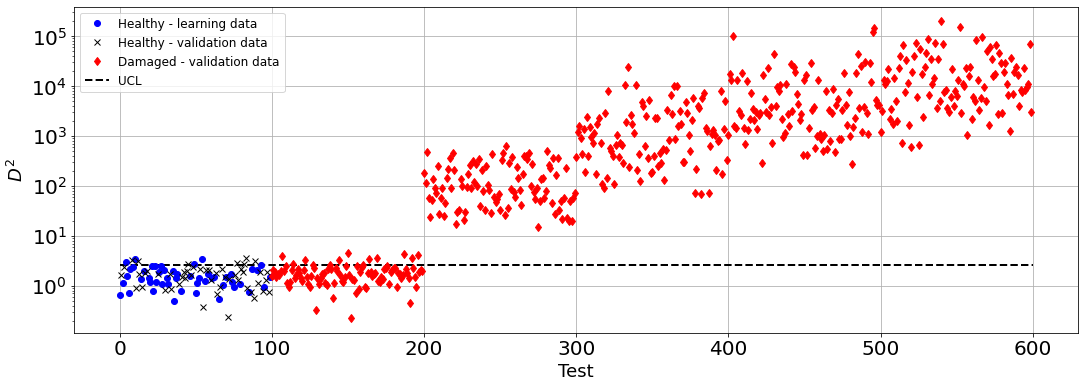

In [99]:
X = np.sort(Disth_dist)
M = np.median(Disth_dist)
X = np.sort(Disth_dist)

aux1 = []
aux2 = []

for i in range(1,len(Disth_dist)):
    if X[i]<M:
      aux1.append(X[i])    
    
    if X[i]>M:
      aux2.append(X[i])
    
Q1 = np.median(aux1) 
Q3 = np.median(aux2)
IQR = Q3-Q1
UCL_IRQ = Q1+1.5*IQR

plt.figure(figsize=(18,6))
plt.plot(learn, Disth_dist, 'bo',label='Healthy - learning data')
plt.plot(valida, Disthv_dist, 'xk',label='Healthy - validation data')
plt.plot(np.arange(100,200,1),Distd_dist_Di[0,:],'dr',label='Damaged - validation data')
plt.plot(np.arange(200,300,1),Distd_dist_Di[10-1,:],'dr')
plt.plot(np.arange(300,400,1),Distd_dist_Di[20-1,:],'dr')
plt.plot(np.arange(400,500,1),Distd_dist_Di[30-1,:],'dr')
plt.plot(np.arange(500,600,1),Distd_dist_Di[38-1,:],'dr')
plt.hlines(UCL_IRQ,0,600,color='black',linestyle='--',linewidth=2,label='UCL')
plt.yscale('log')
plt.legend(loc='best',fontsize=12)
plt.xlabel('Test',fontsize=18)
plt.ylabel('$D^2$',fontsize=18)
plt.grid()
plt.show()

# 5. Compute the confusing matrix with the probability of detection and probability of false alarm. Show the ROC curve.

**Using np.max() as threshold**

In [100]:
import pandas as pd

FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_max = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>np.max(Disth_dist):
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<np.max(Disth_dist):
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_max[i] = TP/(TP+FN[i])

**Using chi-square**

In [101]:
FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_chi2 = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_chi2:
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<UCL_chi2:
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_chi2[i] = TP/(TP+FN[i])

**IQR**

In [102]:
FN = np.zeros(len(Distd_dist_Di))
TN = np.zeros(len(Distd_dist_Di))
recall_IRQ = np.zeros(len(Distd_dist_Di))

for i in range(0,len(Disthv_dist)):
  if Disthv_dist[i]>UCL_IRQ:
    FP += 1

for i in range(0,len(Distd_dist_Di)):
  for j in range(0,len(Distd_dist_Di[0])):
    if Distd_dist_Di[i,j]<UCL_IRQ:
      FN[i] += 1

for i in range(0,len(Disthv_dist)):
  TP = len(Disthv_dist) - FP

for i in range(0,len(Distd_dist_Di)):
  TN[i] = len(Distd_dist_Di) - FN[i]

for i in range(0,len(Distd_dist_Di)):
  recall_IRQ[i] = TP/(TP+FN[i])

**ROC Curve**


Area Under Curve (AUC): 0.98


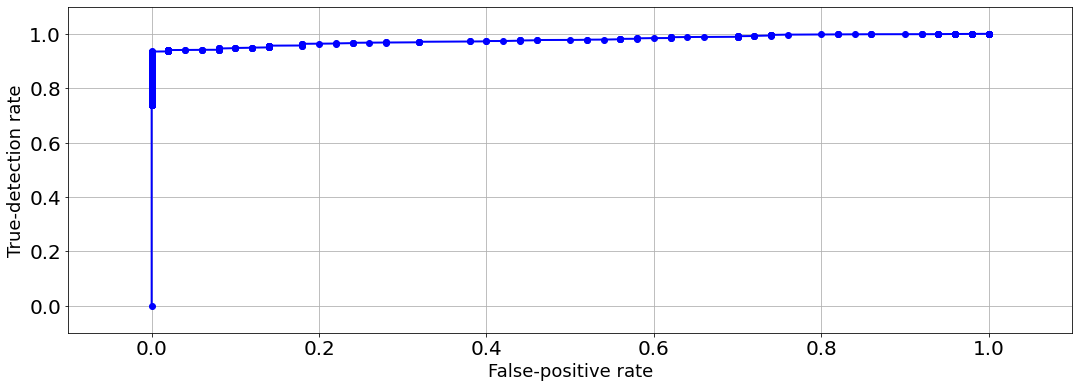

In [103]:
# These values can be changed
n1 = 100
n2 = 5000

false_pos = np.zeros(n2)
true_detec = np.zeros(n2)

decis_di = np.zeros((len(Distd_dist_Di),len(Distd_dist_Di[0])))

for ii in range(0,n2):
  thresh_0 = np.linspace(0,n1,n2)
  y = Disthv_dist

  decis_h = 1*(y > thresh_0[ii])
  false_pos[ii] = np.sum(decis_h)/len(decis_h)

  for j in range(0,len(Distd_dist_Di)):
      ydi = Distd_dist_Di[j]
      decis_di[j,:] = 1*(ydi > thresh_0[ii])

  true_detec[ii] = np.sum(decis_di)/(len(decis_di)*len(decis_di[0]))

false_pos[-1]=0
true_detec[-1]=0

# area under curve
auc = np.trapz(y=true_detec, x=false_pos)

print('')
print('Area Under Curve (AUC): {:.2f}'.format(np.sqrt(auc**2)))

plt.figure(figsize=(18,6))
plt.plot(false_pos,true_detec, 'bo-', linewidth=2)
plt.ylabel('True-detection rate',fontsize=18)
plt.ylim([-0.1, 1.1])
plt.xlim([-0.1, 1.1])
plt.xlabel('False-positive rate',fontsize=18)
plt.grid()
plt.show()

**Comparing Probability of Detection (or recall) and loss of stiffness**

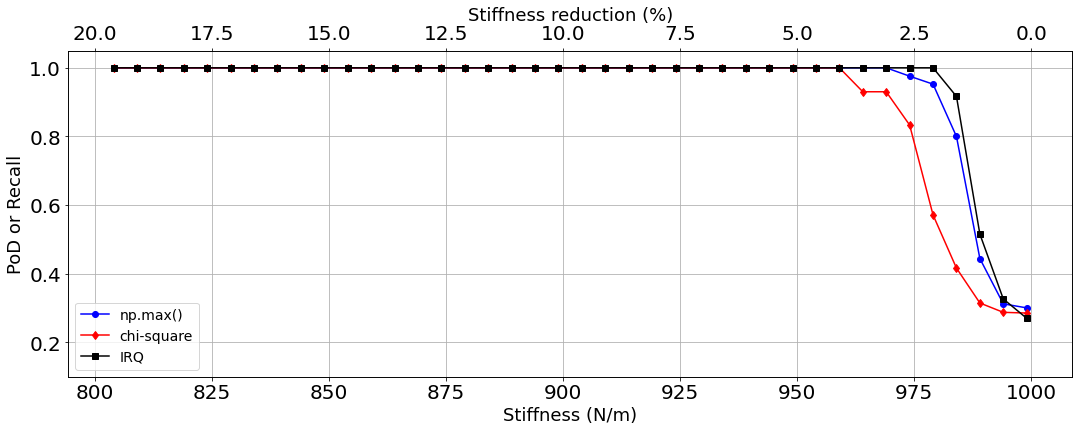

In [104]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(kd,recall_max,'bo-',label='np.max()')
ax1.plot(kd,recall_chi2,'dr-',label='chi-square')
ax1.plot(kd,recall_IRQ,'ks-',label='IRQ')
ax1.set_xlabel('Stiffness (N/m)',fontsize=18)
ax1.set_ylabel('PoD or Recall',fontsize=18)
ax2.plot(100-np.linspace((np.min(kd)/k_0),(np.max(kd)/k_0),len(kd))*100, 1.1*np.ones(len(kd)),'w-')
ax2.set_xlim(ax2.get_xlim()[::-1])
ax2.set_xlabel('Stiffness reduction (%)',fontsize=18)
plt.ylim([0.1,1.05])
ax1.grid()
ax1.legend(loc='best',fontsize=14)
plt.show()

# 7. Show all the results with plots and table with a report.



# 8. Discuss critically your results, disadvantages, and how you can enhance the method.

Para o Caso **A)**, foram verificados apenas 5 casos de situação com dano (perdas de 1%, 10%, 20%, 30% e 34%) na construção da curva ROC e matrizes de confusão, de modo que tal resultado só pode ser levado em consideração na análise qualitativa das *features* utilizadas e do poder de classificação da Distância de Mahalanobis. Observou-se que para baixa perda de rigidez (1%), o método apresenta poucos falsos positivos e falsos negativos (visualmente), com Recall de 0.75 utilizando o threshold via chi-square e Recall de 1.00 via IQR. Obviamente estes resultados mudam com a inclusão de mais estados de dano, como é feito nos casos **B)** e **C)**. Pode-se, no entanto, verificar que as *features* utilizadas contribuem de forma significativa no índice de dano $D^2$ e sua capacidade de classificação.

No Caso **B)**, a ideia é verificar a influência da *feature* índice $\gamma_{AR}$ na classificação. Para este caso, já pode-se tirar conclusões acerca da curva ROC e matrizes de confusão, uma vez que todos os estados com dano são considerados e também diminuiu-se o passo em porcentagem da diminuição de rigidez de 1% para 0.5%, com o intuito de melhorar a visualização gráfica, especialmente no item **6.** que requer a plotagem da variação da rigidez em função do Recall (PoD - Probability of Detection). Foi observado valor de AUC (Area Under Curve) de 0.91 (área sob a curva ROC) e valores de $D^2$ de no máximo ordem $10^2$, que em contraste com o Caso **A)**, indica o efeito da *feature* índice $\gamma_{AR}$.

Ainda no Caso **B)**, *nota-se a melhor abordagem (approach) para o threshold que requer menor porcentagem retirada de rigidez foi o Intervalo Interquartílico (IQR) ou IRQ como mostrado no gráfico, seguida do máximo (`np.max()`) e por último chi-square. Ainda assim, o mínimo valor de rigidez necessário para que a probabilidade de detecção (ou Recall) seja 100% é de pouco menos de 900 N/m aproximadamente (redução próxima de 10%)*. Em comparação com o Caso **C)**, o valor de AUC foi de 0.98 e o mínimo valor de rigidez necessário para Recall de 100% foi de 960 N/m aproximadamente (perda de 4%), isso para a abordagem de threshold com pior resultado (chi-square); para abordagem de threshold IQR (ou IRQ) esse valor cai para uma perda mínima de 2%, resultado consideravelmente superior ao encontrado para o Caso **B)**, de 10%. Isso indica a necessidade de *features* que consigam enxergar a variação nos sinais de forma conjunta a um índice de dano eficiente (como foi o caso, usando Mahalanobis).

Em resumo, a desvantagem encontrada foi a de que, mesmo com uma baixa porcentagem de rigidez retirada, ainda assim não é um resultado completamente satisfatório. Poderia-se, por exemplo, utilizar mais *features* capazes de aumentar a sensibilidade do índice de dano $D^2$ para classificar com Recall de 100% mesmo para pequenas variação em rigidez (menores que 2%). Usar os coeficientes do modelo AR, por exemplo, pode ser uma estratégia para verificar se há melhoras, bem como buscar outras *features* explorando melhor a dinâmica estrutural, a forma da entrada (no caso do tipo aleatório, mas poderia-se fazer uma varredura em frequência com intuito de explorar a física do problema), entre outros.